# 1: Data

In [1]:
!pip -q install yfinance pandas_datareader pyarrow

import os, warnings, logging, contextlib
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)


pairs = [
    ("KO","PEP"),   # Beverages
    ("XOM","CVX"),  # Integrated oil
    ("JPM","BAC"),  # Large US banks
    ("GM","F"),     # Autos
    ("UPS","FDX"),  # Parcel logistics
    ("T","VZ"),     # US telecom
    ("PFE","MRK"),  # Big pharma
    ("UNP","CSX"),  # Railroads
    ("NEE","DUK"),  # Utilities
    ("WMT","TGT"),  # Big-box retail
    ("DIA", "SPY")
]
tickers = [t for p in pairs for t in p]

start_date = "2015-01-01"
end_date   = "2025-01-01"
interval   = "1d"   # keep daily here

def fetch_one_silent(ticker: str) -> pd.Series:
    """Try yfinance history -> yfinance download -> Stooq"""
    # 1) yfinance Ticker().history
    try:
        h = yf.Ticker(ticker).history(start=start_date, end=end_date,
                                      interval=interval, auto_adjust=True)
        if not h.empty and "Close" in h:
            return h["Close"].rename(ticker)
    except Exception:
        pass

    # 2) yfinance.download
    try:
        d = yf.download(ticker, start=start_date, end=end_date,
                        interval=interval, progress=False, threads=False)
        if not d.empty and "Adj Close" in d:
            return d["Adj Close"].rename(ticker)
    except Exception:
        pass

    # 3) Stooq fallback (daily)
    try:
        s = pdr.DataReader(ticker, "stooq", start=start_date, end=end_date)["Close"]
        if not s.empty:
            return s.sort_index().rename(ticker)
    except Exception:
        pass

    # empty series if everything fails
    return pd.Series(name=ticker, dtype="float64")

# build the price table
series_list = [fetch_one_silent(t) for t in tickers]
prices = pd.concat(series_list, axis=1)

# align to business days & forward-fill small gaps
prices = prices.asfreq("B").ffill()

# log levels
log_prices = np.log(prices)

summary = pd.DataFrame({
    "Ticker": prices.columns,
    "NonNullRows": [prices[c].notna().sum() for c in prices.columns],
    "Start": [prices[c].first_valid_index() for c in prices.columns],
    "End":   [prices[c].last_valid_index() for c in prices.columns],
})
print("Downloaded daily prices for selected pairs.")
display(summary)
display(prices.tail())


Downloaded daily prices for selected pairs.


,Ticker,NonNullRows,Start,End
0,KO,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
1,PEP,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
2,XOM,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
3,CVX,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
4,JPM,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
5,BAC,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
6,GM,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
7,F,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
8,UPS,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00
9,FDX,2608,2015-01-02 00:00:00-05:00,2024-12-31 00:00:00-05:00


,KO,PEP,XOM,CVX,JPM,BAC,GM,F,UPS,FDX,...,PFE,MRK,UNP,CSX,NEE,DUK,WMT,TGT,DIA,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-25 00:00:00-05:00,61.467869,148.375336,103.530907,139.002731,237.286896,43.600807,53.067272,9.436645,120.193588,266.917786,...,25.374838,96.665916,225.708130,32.174931,71.183266,106.080452,91.988411,128.404068,427.459229,596.076904
2024-12-26 00:00:00-05:00,61.203770,148.016083,103.618492,139.138031,238.099670,43.767818,53.731731,9.483734,120.288773,273.614319,...,25.204029,97.074173,226.179672,32.125538,70.656052,105.437943,92.097588,132.273651,428.160858,596.116699
2024-12-27 00:00:00-05:00,61.086384,148.453018,103.608765,139.157349,236.170502,43.561504,53.830902,9.446063,120.050789,275.283539,...,25.260965,96.908928,225.884949,32.066265,70.402214,105.467155,90.976021,131.410507,424.988281,589.841614
2024-12-30 00:00:00-05:00,60.675556,147.316986,102.908173,138.258636,234.358887,43.139053,53.216034,9.304796,119.298752,275.470093,...,25.071175,95.616158,223.782593,31.760027,70.060501,104.853859,89.894150,130.974106,420.807587,583.110535
2024-12-31 00:00:00-05:00,60.900536,147.647110,104.669365,139.969101,234.740799,43.178352,52.829258,9.323630,120.041267,276.235962,...,25.175560,96.695091,224.028214,31.878571,69.992157,104.883064,89.675789,131.100159,420.540771,580.989136


In [2]:
# STEP 1 (PART 2): Download hourly (or daily) adjusted close prices

# Use the pairs variable from the first cell
tickers = [t for p in pairs for t in p]

# Define periods
hourly_start = "2023-01-01"   # NOTE:   Yahoo allows 2 years of hourly data
daily_start  = "2015-01-01"
end_date     = "2025-01-01"

def fetch_hourly_or_daily(t):
    """Try to fetch hourly data first; if unavailable, fallback to daily."""
    # 1) Hourly (yfinance)
    try:
        h = yf.Ticker(t).history(start=hourly_start, end=end_date,
                                 interval="1h", auto_adjust=True)
        if not h.empty and "Close" in h:
            return h["Close"].rename(t)
    except Exception:
        pass

    # 2) Daily (yfinance)
    try:
        d = yf.download(t, start=daily_start, end=end_date,
                        interval="1d", progress=False, threads=False)
        if not d.empty and "Adj Close" in d:
            return d["Adj Close"].rename(t)
    except Exception:
        pass

    # 3) Stooq daily fallback
    try:
        s = pdr.DataReader(t, "stooq", start=daily_start, end=end_date)["Close"]
        if not s.empty:
            return s.sort_index().rename(t)
    except Exception:
        pass

    return pd.Series(name=t, dtype="float64")

# Download each ticker
hourly_or_daily_prices = pd.concat([fetch_hourly_or_daily(t) for t in tickers], axis=1)

# Clean up
hourly_or_daily_prices = hourly_or_daily_prices.ffill()

# Log-transform
log_prices_highfreq = np.log(hourly_or_daily_prices)


summary = pd.DataFrame({
    "Ticker": hourly_or_daily_prices.columns,
    "Frequency": ["Hourly" if hourly_or_daily_prices.index.freq is None else "Daily"] * len(hourly_or_daily_prices.columns),
    "NonNullRows": [hourly_or_daily_prices[c].notna().sum() for c in hourly_or_daily_prices.columns],
    "Start": [hourly_or_daily_prices[c].first_valid_index() for c in hourly_or_daily_prices.columns],
    "End":   [hourly_or_daily_prices[c].last_valid_index() for c in hourly_or_daily_prices.columns],
})
print("Hourly (preferred) or daily prices.")
display(summary)
display(hourly_or_daily_prices.tail())

Hourly (preferred) or daily prices.


,Ticker,Frequency,NonNullRows,Start,End
0,KO,Hourly,2516,2015-01-02,2024-12-31
1,PEP,Hourly,2516,2015-01-02,2024-12-31
2,XOM,Hourly,2516,2015-01-02,2024-12-31
3,CVX,Hourly,2516,2015-01-02,2024-12-31
4,JPM,Hourly,2516,2015-01-02,2024-12-31
5,BAC,Hourly,2516,2015-01-02,2024-12-31
6,GM,Hourly,2516,2015-01-02,2024-12-31
7,F,Hourly,2516,2015-01-02,2024-12-31
8,UPS,Hourly,2516,2015-01-02,2024-12-31
9,FDX,Hourly,2516,2015-01-02,2024-12-31


,KO,PEP,XOM,CVX,JPM,BAC,GM,F,UPS,FDX,...,PFE,MRK,UNP,CSX,NEE,DUK,WMT,TGT,DIA,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,62.84,152.81,106.40,143.84,242.31,44.38,53.51,10.02,126.26,271.84,...,26.74,99.45,229.75,32.57,72.91,108.97,92.68,132.40,432.50,599.497
2024-12-26,62.57,152.44,106.49,143.98,243.14,44.55,54.18,10.07,126.36,278.66,...,26.56,99.87,230.23,32.52,72.37,108.31,92.79,136.39,433.21,599.537
2024-12-27,62.45,152.89,106.48,144.00,241.17,44.34,54.28,10.03,126.11,280.36,...,26.62,99.70,229.93,32.46,72.11,108.34,91.66,135.50,430.00,593.226
2024-12-30,62.03,151.72,105.76,143.07,239.32,43.91,53.66,9.88,125.32,280.55,...,26.42,98.37,227.79,32.15,71.76,107.71,90.57,135.05,425.77,586.456
2024-12-31,62.26,152.06,107.57,144.84,239.71,43.95,53.27,9.90,126.10,281.33,...,26.53,99.48,228.04,32.27,71.69,107.74,90.35,135.18,425.50,584.323


In [3]:
# STEP 1 (PART 3): Convert prices to log prices

log_prices_highfreq = np.log(hourly_or_daily_prices)

# Quick check
print("Log prices computed. Shape:", log_prices_highfreq.shape)
display(log_prices_highfreq.tail())

# check for NaN
nan_check = log_prices_highfreq.isna().sum()
print("\nMissing values per column:\n", nan_check)


Log prices computed. Shape: (2516, 22)


,KO,PEP,XOM,CVX,JPM,BAC,GM,F,UPS,FDX,...,PFE,MRK,UNP,CSX,NEE,DUK,WMT,TGT,DIA,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,4.140592,5.029195,4.667206,4.968702,5.490218,3.792789,3.979869,2.304583,4.838343,5.605214,...,3.286161,4.599655,5.436992,3.483392,4.289226,4.691073,4.529153,4.885828,6.069582,6.396091
2024-12-26,4.136286,5.026771,4.668051,4.969674,5.493637,3.796612,3.992312,2.309561,4.839135,5.629992,...,3.279406,4.603869,5.439079,3.481855,4.281792,4.684997,4.530339,4.915518,6.071223,6.396158
2024-12-27,4.134366,5.029719,4.667957,4.969813,5.485502,3.791887,3.994156,2.305581,4.837155,5.636074,...,3.281663,4.602166,5.437775,3.480009,4.278193,4.685274,4.518086,4.908972,6.063785,6.385575
2024-12-30,4.127618,5.022037,4.661172,4.963334,5.477802,3.782142,3.982668,2.290513,4.830870,5.636752,...,3.274121,4.588736,5.428424,3.470412,4.273327,4.679442,4.506123,4.905645,6.053899,6.374098
2024-12-31,4.131319,5.024275,4.678142,4.975630,5.479430,3.783053,3.975373,2.292535,4.837075,5.639528,...,3.278276,4.599957,5.429521,3.474138,4.272351,4.679721,4.503691,4.906607,6.053265,6.370454



Missing values per column:
 KO     0
PEP    0
XOM    0
CVX    0
JPM    0
BAC    0
GM     0
F      0
UPS    0
FDX    0
T      0
VZ     0
PFE    0
MRK    0
UNP    0
CSX    0
NEE    0
DUK    0
WMT    0
TGT    0
DIA    0
SPY    0
dtype: int64


In [4]:
# STEP 1 (PART 4) - Macro data from FRED
!pip -q install pandas_datareader

# Use the same calendar as prices if available
try:
    target_index = hourly_or_daily_prices.index
except NameError:
    target_index = None  # fallback to business-day index

start_date = "2015-01-01"
end_date   = "2025-01-01"

# Pull daily series from FRED
vix  = pdr.DataReader("VIXCLS", "fred", start=start_date, end=end_date)  # VIX close
y10  = pdr.DataReader("DGS10",  "fred", start=start_date, end=end_date)  # 10Y yield
y2   = pdr.DataReader("DGS2",   "fred", start=start_date, end=end_date)  # 2Y yield

# Combine and rename
macro_data = pd.concat([vix, y10, y2], axis=1)
macro_data.columns = ["VIX", "Y10", "Y2"]

# Align to business days and forward-fill
macro_data = macro_data.asfreq("B").ffill()

# If we already have a price index, align to it
if target_index is not None:
    macro_data = macro_data.reindex(target_index).ffill()

# Compute Term Spread (10Y - 2Y), keep only required columns
macro_data["TermSpread"] = macro_data["Y10"] - macro_data["Y2"]
macro_data = macro_data[["VIX", "TermSpread"]]

print("Macro data ready (VIX & TermSpread) — aligned and filled.")
display(macro_data.tail())


Macro data ready (VIX & TermSpread) — aligned and filled.


,VIX,TermSpread
Date,,
2024-12-24,14.27,0.30
2024-12-26,14.73,0.28
2024-12-27,15.95,0.31
2024-12-30,17.40,0.31
2024-12-31,17.35,0.33


In [5]:
# STEP 2 (PART 1): Rolling Correlation Pre-screen

rolling_window = 60
threshold = 0.75  # use the lower bound of the guideline (0.75–0.80)

rolling_corr_summary = []

for t1, t2 in pairs: # Using the pairs variable
    s1 = log_prices_highfreq[t1]
    s2 = log_prices_highfreq[t2]

    # Calculate rolling 60-day Pearson correlation
    rolling_corr = s1.rolling(rolling_window).corr(s2)

    # Compute how often the rolling correlation is above the threshold
    valid = rolling_corr.dropna()
    proportion_above = (valid > threshold).mean()

    # Average rolling correlation as well (for info)
    avg_corr = valid.mean()

    rolling_corr_summary.append({
        "Pair": f"{t1}-{t2}",
        "AvgRollingCorr(60d)": avg_corr,
        "ProportionAboveThreshold": proportion_above
    })

# Convert to DataFrame for clear view
rolling_corr_df = pd.DataFrame(rolling_corr_summary).sort_values("AvgRollingCorr(60d)", ascending=False)

# Keep pairs that have rolling correlation > threshold most of the time
filtered_pairs = rolling_corr_df[rolling_corr_df["ProportionAboveThreshold"] > 0.5]

print(f"Rolling 60-day correlation pre-screen done (threshold={threshold})")
display(rolling_corr_df)
print("\nPairs passing the filter:")
display(filtered_pairs)

Rolling 60-day correlation pre-screen done (threshold=0.75)


,Pair,AvgRollingCorr(60d),ProportionAboveThreshold
10,DIA-SPY,0.925029,0.921042
2,JPM-BAC,0.875557,0.877900
1,XOM-CVX,0.767197,0.700855
7,UNP-CSX,0.729679,0.649980
3,GM-F,0.708496,0.575499
0,KO-PEP,0.690987,0.576313
8,NEE-DUK,0.673322,0.558812
4,UPS-FDX,0.601518,0.411884
5,T-VZ,0.563583,0.413512
6,PFE-MRK,0.367293,0.251933



Pairs passing the filter:


,Pair,AvgRollingCorr(60d),ProportionAboveThreshold
10,DIA-SPY,0.925029,0.921042
2,JPM-BAC,0.875557,0.877900
1,XOM-CVX,0.767197,0.700855
7,UNP-CSX,0.729679,0.649980
3,GM-F,0.708496,0.575499
0,KO-PEP,0.690987,0.576313
8,NEE-DUK,0.673322,0.558812


In [6]:
# STEP 2 (PART 2): Engle–Granger cointegration test on passing pairs
!pip -q install statsmodels

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def engle_granger(series_y, series_x):
    """
    Engle–Granger 2-step:
      1) OLS: y_t = alpha + beta x_t + e_t  (hedge ratio beta)
      2) ADF on residuals e_t
    Returns alpha, beta, adf_stat, pval, nobs
    """
    df = pd.concat([series_y, series_x], axis=1).dropna()
    y = df.iloc[:, 0].values
    x = sm.add_constant(df.iloc[:, 1].values)
    ols_res = sm.OLS(y, x).fit()
    alpha = float(ols_res.params[0])
    beta  = float(ols_res.params[1])
    resid = y - ols_res.predict(x)
    adf_stat, pval, *_ = adfuller(resid, regression='n', autolag='AIC')
    return {
        "alpha": alpha,
        "beta": beta,
        "ADF_stat": adf_stat,
        "p_value": pval,
        "nobs": len(df)
    }

# formation window
formation_window = 750  # trading days approx = 3 years
logP = log_prices_highfreq.copy()

if formation_window is not None and formation_window < len(logP):
    logP_win = logP.tail(formation_window)
else:
    logP_win = logP

# decide which pairs to test: those that passed pre-screen (fallback to all if empty)
if 'filtered_pairs' in locals() and not filtered_pairs.empty:
    pairs_to_test = [tuple(p.split("-")) for p in filtered_pairs["Pair"].tolist()]
else:
    pairs_to_test = pairs

# run tests
rows = []
for a, b in pairs_to_test:
    res = engle_granger(logP_win[a], logP_win[b])
    rows.append({
        "Pair": f"{a}-{b}",
        "alpha": res["alpha"],
        "beta (hedge ratio)": res["beta"],
        "ADF t-stat (resid)": res["ADF_stat"],
        "p-value": res["p_value"],
        "N (obs)": res["nobs"],
        "Cointegrated (p<0.05)": res["p_value"] < 0.05
    })

eg_df = pd.DataFrame(rows).sort_values("p-value")

print(f"Engle–Granger test complete on formation window = {len(logP_win)} trading days")
display(eg_df)


Engle–Granger test complete on formation window = 750 trading days


,Pair,alpha,beta (hedge ratio),ADF t-stat (resid),p-value,N (obs),Cointegrated (p<0.05)
3,UNP-CSX,2.072507,0.957595,-3.577283,0.000365,750,True
0,DIA-SPY,1.877022,0.656010,-2.803952,0.004928,750,True
6,NEE-DUK,-0.208130,0.976499,-2.079368,0.036014,750,True
5,KO-PEP,2.563899,0.302003,-1.891562,0.055838,750,False
2,XOM-CVX,0.437592,0.831607,-1.843942,0.062080,750,False
1,JPM-BAC,2.202499,0.799006,-0.338563,0.561055,750,False
4,GM-F,2.372633,0.528145,-0.269778,0.587672,750,False


In [7]:
# STEP 2 (PART 3): Monthly rolling stability


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# configuration
formation_window = 750        # ~3Y of daily data
min_obs_per_month = 15        # skip very short months
tradable_hl_range = (3, 90)   # days

# slice last N days of log prices used in EG step
logP_win = log_prices_highfreq.tail(formation_window).copy()

def estimate_half_life(residuals: pd.Series) -> float:
    """OU half-life via Δe_t = k * e_{t-1} + ε; return NaN if non-mean-reverting."""
    r = pd.Series(residuals).dropna()
    if len(r) < 3:
        return np.nan
    lag = r.shift(1).dropna()
    delta = r.diff().dropna()
    if len(lag) != len(delta):
        n = min(len(lag), len(delta))
        lag, delta = lag.iloc[-n:], delta.iloc[-n:]
    k = sm.OLS(delta.values, lag.values).fit().params[0]
    if k >= 0:
        return np.nan
    return -np.log(2) / k

def eg_on_window(y: pd.Series, x: pd.Series):
    """OLS y ~ const + x, ADF on residuals (no const); returns alpha,beta,adf,pval."""
    df = pd.concat([y, x], axis=1).dropna()
    if len(df) < min_obs_per_month:
        return None
    yy = df.iloc[:, 0].values
    xx = sm.add_constant(df.iloc[:, 1].values)
    ols = sm.OLS(yy, xx).fit()
    resid = yy - ols.predict(xx)
    adf_stat, pval, *_ = adfuller(resid, regression='n', autolag='AIC')
    hl = estimate_half_life(pd.Series(resid, index=df.index))
    return {
        "alpha": float(ols.params[0]),
        "beta": float(ols.params[1]),
        "ADF_stat": float(adf_stat),
        "p_value": float(pval),
        "HalfLife(days)": hl,
        "N": int(len(df)),
        "StartDate": df.index[0],
        "EndDate": df.index[-1]
    }

# Use pairs that passed pre-screen, or fallback to original 'pairs'
try:
    # Use EG results: keep only cointegrated pairs (p<0.05)
    if 'eg_df' in locals() and not eg_df.empty:
        eg_pass = eg_df[eg_df["Cointegrated (p<0.05)"] == True]
        if not eg_pass.empty:
            pairs_to_check = [tuple(p.split("-")) for p in eg_pass["Pair"].tolist()]
        else:
            print("No pairs passed Engle–Granger (p<0.05) — falling back to all pairs.")
            pairs_to_check = pairs
    else:
        print("eg_df missing or empty — falling back to all pairs.")
        pairs_to_check = pairs
except NameError:
    pairs_to_check = pairs  # fallback if eg_df not defined


rows = []
for a, b in pairs_to_check:
    # monthly windows on the union of both series' index inside the formation window
    both = pd.concat([logP_win[a], logP_win[b]], axis=1).dropna()
    if both.empty:
        continue
    # build month groups from the merged index
    for month, sub in both.resample('M'):
        if len(sub) < min_obs_per_month:
            continue
        res = eg_on_window(sub[a], sub[b])
        if res is None:
            continue
        res.update({"Pair": f"{a}-{b}", "Month": month})
        rows.append(res)

rolling_stability_df = pd.DataFrame(rows)

print(f"Rows generated: {len(rolling_stability_df)}")
if rolling_stability_df.empty:
    print("The table is empty. Most common reasons:\n"
          "- Not enough non-NaN points per month (min_obs_per_month too high)\n"
          "- formation_window too small for your data\n"
          "- Data still contains NaNs before resampling.\n"
          "Try: set min_obs_per_month=10 or formation_window=None to use full history.")
else:
    # tidy columns and display a preview
    rolling_stability_df = rolling_stability_df[
        ["Pair","Month","StartDate","EndDate","N","alpha","beta","ADF_stat","p_value","HalfLife(days)"]
    ].sort_values(["Pair","Month"])
    display(rolling_stability_df.head(12))

    # stability summary per pair
    def pct_tradable_hl(s):
        return np.mean((s >= tradable_hl_range[0]) & (s <= tradable_hl_range[1]))

    summary = (rolling_stability_df
               .assign(cointeg=lambda d: d["p_value"] < 0.05)
               .groupby("Pair")
               .agg(months=("Month", "size"),
                    pct_months_cointegrated=("cointeg", "mean"),
                    beta_mean=("beta", "mean"),
                    beta_std=("beta", "std"),
                    hl_median=("HalfLife(days)", "median"),
                    pct_hl_tradable=("HalfLife(days)", pct_tradable_hl))
               .reset_index())

    print("\nStability summary (per pair):")
    display(summary)

    # filter pairs that look stable by simple rules
    stable = summary.query("pct_months_cointegrated >= 0.6 and pct_hl_tradable >= 0.6 and beta_std <= 0.2")
    print("\nPairs passing simple stability rules (>=60% months cointegrated, >=60% tradable half-life, beta std <= 0.2):")
    display(stable)

Rows generated: 108


,Pair,Month,StartDate,EndDate,N,alpha,beta,ADF_stat,p_value,HalfLife(days)
36,DIA-SPY,2022-01-31,2022-01-06,2022-01-31,17,1.284926,0.754535,-0.852787,3.484351e-01,1.495346
37,DIA-SPY,2022-02-28,2022-02-01,2022-02-28,19,-0.212059,1.002180,-2.389765,1.625565e-02,1.145708
38,DIA-SPY,2022-03-31,2022-03-01,2022-03-31,23,1.536176,0.711105,-4.652509,4.910608e-06,3.302847
39,DIA-SPY,2022-04-30,2022-04-01,2022-04-29,20,2.494830,0.553533,-0.000000,6.842796e-01,2.336027
40,DIA-SPY,2022-05-31,2022-05-02,2022-05-31,21,0.963864,0.808587,-1.335779,1.682649e-01,1.368969
41,DIA-SPY,2022-06-30,2022-06-01,2022-06-30,21,0.773769,0.840398,-4.243760,2.750074e-05,0.928599
42,DIA-SPY,2022-07-31,2022-07-01,2022-07-29,20,1.046461,0.794141,-0.000000,6.842796e-01,1.022832
43,DIA-SPY,2022-08-31,2022-08-01,2022-08-31,23,0.216673,0.932144,-2.214839,2.572436e-02,1.938207
44,DIA-SPY,2022-09-30,2022-09-01,2022-09-30,21,0.312773,0.915280,-0.745718,3.933476e-01,1.634373
45,DIA-SPY,2022-10-31,2022-10-03,2022-10-31,21,-1.864048,1.289675,-1.392504,1.523917e-01,3.749051



Stability summary (per pair):


,Pair,months,pct_months_cointegrated,beta_mean,beta_std,hl_median,pct_hl_tradable
0,DIA-SPY,36,0.333333,0.756665,0.296501,1.854665,0.222222
1,NEE-DUK,36,0.305556,0.990373,0.594683,2.053835,0.305556
2,UNP-CSX,36,0.305556,0.637142,0.487435,1.966560,0.277778



Pairs passing simple stability rules (>=60% months cointegrated, >=60% tradable half-life, beta std <= 0.2):


,Pair,months,pct_months_cointegrated,beta_mean,beta_std,hl_median,pct_hl_tradable


In [8]:
# STEP 2 (PART 4): OU parameter estimation and tradable shortlist

from statsmodels.tsa.stattools import adfuller


# choose which pairs to evaluate
# Use filtered pairs from pre-screen if available, else use all 'pairs'
try:
    pairs_to_eval = [tuple(p.split("-")) for p in filtered_pairs["Pair"].tolist()]
    if not pairs_to_eval:  # empty df
        pairs_to_eval = pairs
except Exception:
    pairs_to_eval = pairs


# set formation window
formation_window = 750   # ~3y of daily data
logP = log_prices_highfreq.copy()
if formation_window is not None and formation_window < len(logP):
    logP = logP.tail(formation_window)

# detect frequency to set tradable half-life bands
# (business-day daily vs. hourly)
def infer_freq_days(index: pd.Index) -> float:
    """Median spacing in days (e.g., ~1.0 for daily BDays; ~0.04 for hourly)."""
    if len(index) < 3:
        return 1.0
    d = pd.Series(index).diff().dropna().median()
    return d.total_seconds() / (24 * 3600)

median_days = infer_freq_days(logP.index)
is_hourly = median_days < 0.2   # ~< 5 hours per step → treat as hourly

# ADF p-value gate on the spread (stationarity requirement)
p_thresh = 0.10  # accept if ADF_p(spread) ≤ 0.10 (looser than 0.05 but still meaningful)

# Half-life band (measured in hours if hourly data, in days if daily data)
if is_hourly:
    hl_min, hl_max = 10, 120    # hours; allow 10–120h mean-reversion
else:
    hl_min, hl_max = 3, 90

def hedge_ratio_beta(y, x):
    """OLS: y ~ const + beta*x -> return beta and alpha."""
    df = pd.concat([y, x], axis=1).dropna()
    if df.empty:
        return np.nan, np.nan
    X = sm.add_constant(df.iloc[:,1].values)
    res = sm.OLS(df.iloc[:,0].values, X).fit()
    return float(res.params[1]), float(res.params[0])

def ou_params_from_spread(spread: pd.Series):
    """Estimate κ, μ, σ, half-life from OU: ΔS_t = κ(μ - S_{t-1}) + σ ε_t."""
    s = spread.dropna()
    if len(s) < 60:
        return dict(kappa=np.nan, mu=np.nan, sigma=np.nan, half_life=np.nan, n_obs=len(s))

    s_lag = s.shift(1).dropna()
    ds = s.diff().dropna()
    # align
    n = min(len(s_lag), len(ds))
    s_lag, ds = s_lag.iloc[-n:], ds.iloc[-n:]

    X = sm.add_constant(s_lag.values)
    fit = sm.OLS(ds.values, X).fit()
    a, b = fit.params  # ΔS = a + b*S_{t-1}
    kappa = -b
    mu = (a / kappa) if kappa != 0 else np.nan
    sigma = np.std(fit.resid, ddof=1)
    half_life = (np.log(2) / kappa) if kappa > 0 else np.nan
    return dict(kappa=kappa, mu=mu, sigma=sigma, half_life=half_life, n_obs=len(s))

def adf_pvalue(series: pd.Series):
    s = series.dropna()
    if len(s) < 60:
        return np.nan, np.nan
    stat, pval, *_ = adfuller(s, regression='c', autolag='AIC')  # just for info on spread
    return float(stat), float(pval)

# ---- run for each pair ----
rows = []
for a, b in pairs_to_eval:
    y = logP[a]
    x = logP[b]

    beta, alpha = hedge_ratio_beta(y, x)
    spread = y - beta * x - alpha  # de-mean via alpha from OLS

    ou = ou_params_from_spread(spread)
    stat, pval = adf_pvalue(spread)

    rows.append({
        "Pair": f"{a}-{b}",
        "beta (hedge)": beta,
        "alpha": alpha,
        "kappa": ou["kappa"],
        "mu": ou["mu"],
        "sigma": ou["sigma"],
        "half_life": ou["half_life"],
        "n_obs": ou["n_obs"],
        "ADF_stat(spread)": stat,
        "ADF_p(spread)": pval
    })

ou_table = (pd.DataFrame(rows)
            .assign(tradable=lambda d: (d["half_life"] >= hl_min) & (d["half_life"] <= hl_max))
            .sort_values("ADF_p(spread)"))

print(f" OU parameters estimated on {len(logP)} rows "
      f"({'hourly' if is_hourly else 'daily'}); tradable half-life band = [{hl_min}, {hl_max}]")
display(ou_table)

shortlist = ou_table[ou_table["tradable"]].copy()
print("\n Shortlist of pairs with tradable half-life:")
display(shortlist if not shortlist.empty else pd.DataFrame(
    {"Note": [f"No pairs met half-life in [{hl_min}, {hl_max}] for this frequency."]}))

 OU parameters estimated on 750 rows (daily); tradable half-life band = [3, 90]


,Pair,beta (hedge),alpha,kappa,mu,sigma,half_life,n_obs,ADF_stat(spread),ADF_p(spread),tradable
3,UNP-CSX,0.957595,2.072507,0.028570,0.002487,0.010886,24.261126,750,-3.575314,0.006251,True
0,DIA-SPY,0.656010,1.877022,0.017572,-0.001046,0.003775,39.445867,750,-2.802116,0.057972,True
6,NEE-DUK,0.976499,-0.208130,0.010547,-0.029655,0.014067,65.722080,750,-2.077776,0.253545,True
5,KO-PEP,0.302003,2.563899,0.009703,0.012428,0.007716,71.439347,750,-1.890007,0.336777,True
2,XOM-CVX,0.831607,0.437592,0.005122,0.085695,0.009375,135.338763,750,-1.848391,0.356715,False
1,JPM-BAC,0.799006,2.202499,0.000759,0.790422,0.009441,913.004498,750,-0.332557,0.920765,False
4,GM-F,0.528145,2.372633,0.000952,0.343255,0.014879,727.870024,750,-0.267604,0.929969,False



 Shortlist of pairs with tradable half-life:


,Pair,beta (hedge),alpha,kappa,mu,sigma,half_life,n_obs,ADF_stat(spread),ADF_p(spread),tradable
3,UNP-CSX,0.957595,2.072507,0.028570,0.002487,0.010886,24.261126,750,-3.575314,0.006251,True
0,DIA-SPY,0.656010,1.877022,0.017572,-0.001046,0.003775,39.445867,750,-2.802116,0.057972,True
6,NEE-DUK,0.976499,-0.208130,0.010547,-0.029655,0.014067,65.722080,750,-2.077776,0.253545,True
5,KO-PEP,0.302003,2.563899,0.009703,0.012428,0.007716,71.439347,750,-1.890007,0.336777,True


In [9]:


EG_P = 0.10  # was 0.05; relax slightly

if 'median_days' not in globals():
    # reuse your helper if needed
    def infer_freq_days(index: pd.Index) -> float:
        if len(index) < 3: return 1.0
        d = pd.Series(index).diff().dropna().median()
        return d.total_seconds() / (24*3600)
    median_days = infer_freq_days(log_prices_highfreq.index)

is_hourly = median_days < 0.2
if is_hourly:
    hl_min, hl_max = 8, 120   # hours (wider)
else:
    hl_min, hl_max = 3, 70    # days (wider)

eg_pass_df = eg_df.loc[eg_df["p-value"] < EG_P, ["Pair","p-value"]].copy()
hl_pass_df = ou_table.loc[ou_table["half_life"].between(hl_min, hl_max), ["Pair","half_life"]].copy()

eg_pass = set(eg_pass_df["Pair"])
hl_pass = set(hl_pass_df["Pair"])

# Primary: intersection
chosen = list(eg_pass & hl_pass)

# Fallback 1: if empty, use union but keep top EG by p-value
if not chosen:
    print("No pairs in EG∩HL; using EG∪HL (kept by EG p-value).")
    union = eg_pass | hl_pass
    tmp = eg_pass_df.set_index("Pair").reindex(list(union)).sort_values("p-value")
    chosen = tmp.index.tolist()

# Fallback 2: still empty? just take top 3 by EG p-value overall
if not chosen:
    print("EG∪HL empty; taking top by EG p-value.")
    chosen = eg_df.nsmallest(3, "p-value")["Pair"].tolist()

# Limit duplicates and keep at most K pairs
K = 4
chosen = chosen[:K]

pairs_to_feature = [tuple(p.split("-")) for p in chosen]
print("Pairs going into feature/label steps:", pairs_to_feature)
print(f"EG_P={EG_P}, HL band={[hl_min, hl_max]} ({'hourly' if is_hourly else 'daily'})")

Pairs going into feature/label steps: [('NEE', 'DUK'), ('UNP', 'CSX'), ('DIA', 'SPY')]
EG_P=0.1, HL band=[3, 70] (daily)


In [10]:
# Diagnostic: See which pairs were finally selected and why
print("\n Diagnostic — Pair selection summary (EG + Half-life + filter status):")

# Ensure we have both data sources
if 'eg_df' in globals() and 'ou_table' in globals():
    eg_df_subset = eg_df[["Pair", "p-value"]].copy()
    ou_subset = ou_table[["Pair", "half_life"]].copy()

    merged = (eg_df_subset
              .merge(ou_subset, on="Pair", how="outer")
              .sort_values("p-value"))

    # Define thresholds used
    EG_P = 0.10
    if 'hl_min' not in globals(): hl_min, hl_max = 3, 90

    merged["EG_pass"] = merged["p-value"] < EG_P
    merged["HL_pass"] = merged["half_life"].between(hl_min, hl_max)

    # Mark which ones were actually selected
    if 'pairs_to_feature' in globals():
        chosen_pairs = [f"{a}-{b}" for (a,b) in pairs_to_feature]
        merged["Selected"] = merged["Pair"].isin(chosen_pairs)
    else:
        merged["Selected"] = False

    display(merged[["Pair", "p-value", "half_life", "EG_pass", "HL_pass", "Selected"]]
            .sort_values(["Selected", "p-value"], ascending=[False, True]))

    # Quick summary counts
    print("\nSummary counts:")
    print(f"EG pass (p<{EG_P}): {merged['EG_pass'].sum()} / {len(merged)}")
    print(f"Half-life pass [{hl_min}, {hl_max}]: {merged['HL_pass'].sum()} / {len(merged)}")
    print(f"Selected for features: {merged['Selected'].sum()} / {len(merged)}")

else:
    print("Missing eg_df or ou_table — run EG and OU parameter steps first.")


 Diagnostic — Pair selection summary (EG + Half-life + filter status):


,Pair,p-value,half_life,EG_pass,HL_pass,Selected
5,UNP-CSX,0.000365,24.261126,True,True,True
0,DIA-SPY,0.004928,39.445867,True,True,True
4,NEE-DUK,0.036014,65.722080,True,True,True
3,KO-PEP,0.055838,71.439347,True,False,False
6,XOM-CVX,0.062080,135.338763,True,False,False
2,JPM-BAC,0.561055,913.004498,False,False,False
1,GM-F,0.587672,727.870024,False,False,False



Summary counts:
EG pass (p<0.1): 5 / 7
Half-life pass [3, 70]: 3 / 7
Selected for features: 3 / 7


In [11]:
# STEP 3 (PART 1): Rolling econometric features

from statsmodels.tsa.stattools import adfuller

# Use the pairs variable from the first cell
window = 60  # rolling window length

def ou_params_window(s: pd.Series):
    """Estimate OU params on a window s of spread."""
    s = pd.Series(s).dropna()
    if len(s) < 20:
        return np.nan, np.nan, np.nan, np.nan
    s_lag = s.shift(1).dropna()
    ds = s.diff().dropna()
    n = min(len(s_lag), len(ds))
    s_lag, ds = s_lag.iloc[-n:], ds.iloc[-n:]
    X = sm.add_constant(s_lag.values)
    fit = sm.OLS(ds.values, X).fit()
    a, b = fit.params  # ΔS = a + b S_{t-1}
    kappa = -b
    mu = (a / kappa) if kappa != 0 else np.nan
    sigma = np.std(fit.resid, ddof=1)
    hl = np.log(2) / kappa if kappa > 0 else np.nan
    return kappa, mu, sigma, hl

def adf_tstat_window(s: pd.Series):
    s = pd.Series(s).dropna()
    if len(s) < 20:
        return np.nan
    stat, _p, *_ = adfuller(s, regression='c', autolag='AIC')
    return float(stat)

# def hurst_exponent(s: pd.Series):
#     s = pd.Series(s).dropna()
#     if len(s) < 40:
#         return np.nan
#     lags = range(2, 20)
#     tau = [np.sqrt(np.std(np.subtract(s[lag:], s[:-lag]))) for lag in lags]
#     reg = sm.OLS(np.log(tau), sm.add_constant(np.log(list(lags)))).fit()
#     return float(reg.params[1])
def hurst_exponent(s: pd.Series,
                        lags=range(2, 40),
                        min_lags=8,
                        eps=1e-8) -> float:
    """
    Robust Hurst via dispersion scaling:
    std(diff_lag) ~ lag^H  =>  log(std) = H*log(lag) + c
    - Filters zero/near-zero std to avoid log(0)
    - Requires at least `min_lags` valid points
    - Falls back to variance-time method if needed
    """
    s = pd.Series(s).dropna()
    if len(s) < (max(lags) + 1):
        return np.nan

    taus, used = [], []
    for L in lags:
        diff = s.diff(L).dropna()
        sd = float(diff.std(ddof=1))
        if np.isfinite(sd) and sd > eps:
            taus.append(sd)
            used.append(L)

    if len(taus) >= min_lags:
        y = np.log(np.asarray(taus))
        X = sm.add_constant(np.log(np.asarray(used)))
        try:
            H = float(sm.OLS(y, X).fit().params[1])
            if np.isfinite(H):
                return max(0.0, min(1.5, H))  # clamp to a sensible range
        except Exception:
            pass

    # fallback: variance-time
    blocks = [2,4,8,16,32]
    vars_, blks = [], []
    for m in blocks:
        if len(s) >= m + 1:
            ma = s.rolling(m).mean().dropna()
            v = float(ma.var(ddof=1))
            if np.isfinite(v) and v > eps:
                vars_.append(v); blks.append(m)
    if len(vars_) >= 3:
        slope = np.polyfit(np.log(blks), np.log(vars_), 1)[0]
        H = 0.5 * slope  # var(mean over block m) ~ m^{2H-2}
        return max(0.0, min(1.5, float(H)))

    return np.nan

def momentum_slope(s: pd.Series, lookback=5):
    s = pd.Series(s).dropna()
    if len(s) < lookback:
        return np.nan
    y = s.iloc[-lookback:]
    X = sm.add_constant(np.arange(lookback))
    return float(sm.OLS(y.values, X).fit().params[1])

all_features = []

for a, b in pairs_to_feature:
    y = log_prices_highfreq[a]
    x = log_prices_highfreq[b]

    # hedge ratio from recent 750 bars (or full if shorter)
    nfit = min(750, len(y.dropna()), len(x.dropna()))
    beta_model = sm.OLS(y.tail(nfit), sm.add_constant(x.tail(nfit))).fit()
    beta, alpha = float(beta_model.params[1]), float(beta_model.params[0])

    spread = (y - beta*x - alpha).dropna()

    # add rolling spread z-score as features (aligned with window outputs)
    roll_mu = spread.rolling(window).mean()
    roll_sd = spread.rolling(window).std()
    spread_z = (spread - roll_mu) / roll_sd

    # Iterate over rolling windows
    idx = spread.index
    i0 = window - 1
    kappas, mus, sigmas, hls, adfs, hursts, moms, out_idx = [], [], [], [], [], [], [], []

    for i in range(i0, len(spread)):
        w = spread.iloc[i-window+1:i+1]

        k, m, s, hl = ou_params_window(w)
        a_stat = adf_tstat_window(w)
        h_est = hurst_exponent(w)
        mom = momentum_slope(w)

        kappas.append(k); mus.append(m); sigmas.append(s); hls.append(hl)
        adfs.append(a_stat); hursts.append(h_est); moms.append(mom)
        out_idx.append(idx[i])

    # align z to the output timestamps
    z_vals = spread_z.reindex(out_idx)
    abs_z_vals = z_vals.abs()

    df_feat = pd.DataFrame({
        "kappa": kappas,
        "mu": mus,
        "sigma": sigmas,
        "half_life": hls,
        "adf_tstat": adfs,
        "hurst": hursts,
        "momentum": moms,
        "z": z_vals.values,         # NEW
        "abs_z": abs_z_vals.values, # NEW
        "pair": f"{a}-{b}",
    }, index=pd.Index(out_idx, name="Date"))

    all_features.append(df_feat)

features_df = pd.concat(all_features).sort_index()
print("Rolling econometric features computed.")
display(features_df.head(10))

Rolling econometric features computed.


,kappa,mu,sigma,half_life,adf_tstat,hurst,momentum,z,abs_z,pair
Date,,,,,,,,,,
2015-03-30,-0.001846,-1.412791,0.006777,NaN,0.070781,0.187927,0.000309,1.650056,1.650056,NEE-DUK
2015-03-30,0.263457,-0.192193,0.003571,2.630968,-2.946327,0.022457,-0.000169,0.290113,0.290113,DIA-SPY
2015-03-30,0.108986,0.300043,0.011419,6.359938,-2.371869,0.284844,-0.003904,-1.281803,1.281803,UNP-CSX
2015-03-31,0.012896,-0.608775,0.007199,53.747623,-0.475372,0.157647,-0.003544,1.103951,1.103951,NEE-DUK
2015-03-31,0.261355,-0.192187,0.003569,2.652133,-2.921985,0.043991,0.000996,-0.592713,0.592713,DIA-SPY
2015-03-31,0.105393,0.299652,0.011460,6.576793,-1.975820,0.289286,-0.001932,-1.636531,1.636531,UNP-CSX
2015-04-01,0.013416,-0.587952,0.007020,51.665308,-0.511272,0.128187,-0.004302,1.233293,1.233293,NEE-DUK
2015-04-01,0.260887,-0.192174,0.003566,2.656887,-2.921657,0.070972,0.000215,-0.990187,0.990187,DIA-SPY
2015-04-01,0.065505,0.289542,0.011635,10.581651,-1.059907,0.292388,-0.002418,-2.280155,2.280155,UNP-CSX


In [12]:
features_df.tail(10)

,kappa,mu,sigma,half_life,adf_tstat,hurst,momentum,z,abs_z,pair
Date,,,,,,,,,,
2024-12-26,0.101439,-0.073753,0.011353,6.833116,-2.441947,0.217050,6.182045e-03,-0.829918,0.829918,NEE-DUK
2024-12-27,0.113491,-0.074745,0.011260,6.107506,-2.360828,0.213844,1.175364e-03,-0.930368,0.930368,NEE-DUK
2024-12-27,0.061848,0.011100,0.004586,11.207186,-2.233634,0.170601,9.912310e-05,-1.287452,1.287452,DIA-SPY
2024-12-27,0.108296,0.007984,0.010757,6.400501,-1.040425,0.249927,-2.078223e-07,1.050165,1.050165,UNP-CSX
2024-12-30,0.054614,0.009191,0.004596,12.691785,-1.947971,0.193204,8.521953e-05,-1.442443,1.442443,DIA-SPY
2024-12-30,0.127682,-0.074713,0.011172,5.428682,-2.464541,0.204688,-1.026226e-03,-0.886304,0.886304,NEE-DUK
2024-12-30,0.095522,0.011184,0.010565,7.256403,-0.984023,0.267637,1.399137e-03,1.040251,1.040251,UNP-CSX
2024-12-31,0.098100,0.008367,0.010366,7.065737,-1.060883,0.289150,3.083957e-04,0.917069,0.917069,UNP-CSX
2024-12-31,0.127613,-0.075235,0.011178,5.431654,-2.381763,0.191806,-1.461937e-03,-0.916014,0.916014,NEE-DUK


In [13]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.7 MB/s eta 0:00:00


In [14]:
# STEP 3 (PARTS 2 & 3): HMM regime features + Macro features
# Uses:
#   - log_prices_highfreq  (from Step 1.3)
#   - macro_data           (from Step 1.4)
#   - pairs_to_feature     (from Step 3.1)
#   - features_df


try:
    from hmmlearn.hmm import GaussianHMM
except Exception as e:
    raise ImportError("Install hmmlearn first: pip install hmmlearn") from e

def hmm_filtered_probs_from_spread(
    spread: pd.Series,
    n_states: int = 3,
    min_train: int = 126,      # was 252; loosen to avoid short-sample issues
    refit_every: int = 20,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Expanding-window Gaussian HMM on ΔS_t (no look-ahead), robust to NaNs/degenerate windows.
    Returns filtered probabilities.
    """
    # 1) Build return series and keep only finite values
    ret = spread.diff()
    ret = ret[np.isfinite(ret)]
    if ret.empty:
        return pd.DataFrame(index=spread.index,
                            columns=[f"hmm_p_state{k}" for k in range(n_states)])

    X_all = ret.values.reshape(-1, 1)

    # 2) Output frame (aligned to spread index; note: ret[t] -> spread[t+1])
    probs = pd.DataFrame(
        np.nan,
        index=spread.index,
        columns=[f"hmm_p_state{k}" for k in range(n_states)]
    )

    # 3) Helper: build a fresh HMM with safe initialization
    def _new_hmm():
        m = GaussianHMM(
            n_components=n_states,
            covariance_type="diag",
            n_iter=200,
            tol=1e-3,
            random_state=random_state,
            init_params="mc",
            params="stmc"       # learn all params during EM
        )
        m.startprob_ = np.full(n_states, 1.0 / n_states)
        m.transmat_  = np.full((n_states, n_states), 1.0 / n_states)
        return m

    model = None
    last_fit = -10**9

    # 4) Walk forward
    for t in range(min_train, len(X_all)):
        # (re)fit periodically on the data up to t-1
        if (model is None) or (t - last_fit >= refit_every):
            X_train = X_all[:t]  # up to t-1

            # guard against tiny or constant windows (hmmlearn can blow up)
            if (len(X_train) < max(min_train, n_states * 10)) or np.allclose(X_train.std(), 0.0):
                # skip refit and keep previous model if any; else leave as None
                continue

            try:
                model = _new_hmm()
                model.fit(X_train)
                last_fit = t
            except Exception:
                # keep previous model; if none, skip until we can fit
                continue

        # predict prob for ret[t] (maps to spread index t+1 in ret’s index)
        try:
            p = model.predict_proba(X_all[t].reshape(1, -1)).ravel()
            # Align: ret.index[t] corresponds to spread.index position of ret at t,
            # the filtered prob is for the NEXT state → write at the next timestamp if available
            # We'll align to the *same* timestamp as ret for simplicity:
            ts = ret.index[t]
            probs.loc[ts, :] = p
        except Exception:
            # leave NaNs for this step if prediction fails
            pass

    return probs

def make_macro_features_aligned(price_index: pd.DatetimeIndex,
                                macro: pd.DataFrame,
                                roll_z_win: int = 60) -> pd.DataFrame:
    """
    Forward-fill macro series to price frequency and create z-scores / changes.
    Expects columns: ["VIX", "TermSpread"].
    """
    m = (macro[["VIX","TermSpread"]]
         .sort_index()
         .reindex(price_index, method="ffill"))

    feats = pd.DataFrame(index=price_index)
    # rolling z-scores (no look-ahead)
    for col, zname in [("VIX","vix_z"), ("TermSpread","term_z")]:
        mu = m[col].rolling(roll_z_win, min_periods=roll_z_win//2).mean()
        sd = m[col].rolling(roll_z_win, min_periods=roll_z_win//2).std()
        feats[zname] = (m[col] - mu) / sd
        feats[f"{col.lower()}_chg_5"] = m[col].diff(5)
    # also keep the raw term spread if you like
    feats["term_spread"] = m["TermSpread"]
    return feats

# Build HMM probs and macro features for each pair and merge
combined_blocks = []

# Use pairs_to_feature
for a, b in pairs_to_feature:
    # 1) construct spread with a hedge ratio
    y = log_prices_highfreq[a]
    x = log_prices_highfreq[b]
    # robust beta/alpha fit on last 750 bars
    nfit = min(750, len(y.dropna()), len(x.dropna()))
    import statsmodels.api as sm
    beta_model = sm.OLS(y.tail(nfit), sm.add_constant(x.tail(nfit))).fit()
    beta, alpha = float(beta_model.params[1]), float(beta_model.params[0])

    spread = (y - beta*x - alpha).dropna()

    # 2) HMM filtered probabilities
    hmm_probs = hmm_filtered_probs_from_spread(
        spread=spread, n_states=3, min_train=252, refit_every=20
    )

    # 3) Macro features aligned to asset timestamps
    macro_feats = make_macro_features_aligned(spread.index, macro_data)

    # 4) Join them
    f_pair = (pd.concat([hmm_probs, macro_feats], axis=1)
                .assign(pair=f"{a}-{b}")
                .rename_axis("Date")
              )
    combined_blocks.append(f_pair)

# All HMM+macro features across pairs
hmm_macro_df = (pd.concat(combined_blocks)
                .sort_index()
               )

# 5) Merge with your existing rolling econometric features
#    Both have a "pair" column and Date index; join on both keys
features_df = features_df.copy()
features_df.index.name = "Date"  # ensure named index
full_features = (features_df
                 .reset_index()
                 .merge(hmm_macro_df.reset_index(), on=["Date","pair"], how="left")
                 .set_index("Date")
                 .sort_index()
                )

print("HMM regime probabilities + macro features created and merged.")
display(full_features.tail(10))

HMM regime probabilities + macro features created and merged.


,kappa,mu,sigma,half_life,adf_tstat,hurst,momentum,z,abs_z,pair,hmm_p_state0,hmm_p_state1,hmm_p_state2,vix_z,vix_chg_5,term_z,termspread_chg_5,term_spread
Date,,,,,,,,,,,,,,,,,,
2024-12-26,0.101439,-0.073753,0.011353,6.833116,-2.441947,0.217050,6.182045e-03,-0.829918,0.829918,NEE-DUK,0.999990,0.000010,6.199615e-36,-0.802419,-12.89,2.554616,0.13,0.28
2024-12-27,0.113491,-0.074745,0.011260,6.107506,-2.360828,0.213844,1.175364e-03,-0.930368,0.930368,NEE-DUK,0.999994,0.000006,8.275797e-37,-0.422842,-8.14,2.793167,0.06,0.31
2024-12-27,0.061848,0.011100,0.004586,11.207186,-2.233634,0.170601,9.912310e-05,-1.287452,1.287452,DIA-SPY,0.523828,0.476169,2.146039e-06,-0.422842,-8.14,2.793167,0.06,0.31
2024-12-27,0.108296,0.007984,0.010757,6.400501,-1.040425,0.249927,-2.078223e-07,1.050165,1.050165,UNP-CSX,0.882283,0.117717,5.260947e-18,-0.422842,-8.14,2.793167,0.06,0.31
2024-12-30,0.054614,0.009191,0.004596,12.691785,-1.947971,0.193204,8.521953e-05,-1.442443,1.442443,DIA-SPY,0.521552,0.478445,2.449224e-06,0.026579,-0.96,2.593083,0.09,0.31
2024-12-30,0.127682,-0.074713,0.011172,5.428682,-2.464541,0.204688,-1.026226e-03,-0.886304,0.886304,NEE-DUK,0.999995,0.000005,6.614009e-37,0.026579,-0.96,2.593083,0.09,0.31
2024-12-30,0.095522,0.011184,0.010565,7.256403,-0.984023,0.267637,1.399137e-03,1.040251,1.040251,UNP-CSX,0.882277,0.117723,5.251589e-18,0.026579,-0.96,2.593083,0.09,0.31
2024-12-31,0.098100,0.008367,0.010366,7.065737,-1.060883,0.289150,3.083957e-04,0.917069,0.917069,UNP-CSX,0.877445,0.122555,5.464530e-18,0.020910,0.57,2.655842,0.04,0.33
2024-12-31,0.127613,-0.075235,0.011178,5.431654,-2.381763,0.191806,-1.461937e-03,-0.916014,0.916014,NEE-DUK,0.999995,0.000005,6.916454e-37,0.020910,0.57,2.655842,0.04,0.33


In [15]:
# STEP 4 — Label Generation via forward PnL simulation (z-score entry/exit)
# Inputs expected from previous steps:
# - log_prices_highfreq : DataFrame of log prices (columns are tickers)
# - pairs_to_feature    : list of (A, B) tickers you are trading as pairs
# - full_features       : DataFrame from Step 3 (econometric + HMM + macro), with 'pair' column


def rolling_hedge_alpha_beta(y: pd.Series, x: pd.Series, win: int = 252) -> tuple[pd.Series, pd.Series]:
    """
    Rolling OLS via rolling moments
    Returns alpha_t and beta_t aligned with y/x index.
    Uses only historical info within each window (no look-ahead).
    """
    # rolling means
    mx = x.rolling(win).mean()
    my = y.rolling(win).mean()
    # rolling centered series
    xc = x - mx
    yc = y - my
    # rolling var/cov
    varx = (xc * xc).rolling(win).mean()
    covxy = (xc * yc).rolling(win).mean()
    beta = covxy / varx
    alpha = my - beta * mx
    return alpha, beta

def spread_and_zscore(y: pd.Series, x: pd.Series, win_beta: int = 252, win_z: int = 60) -> pd.DataFrame:
    """
    Build leakage-safe spread S_t and z-score z_t.
    - alpha_t, beta_t computed from last win_beta bars only.
    - z_t uses rolling mean/std of S_t over last win_z bars only.
    """
    alpha_t, beta_t = rolling_hedge_alpha_beta(y, x, win=win_beta)
    spread = y - (beta_t * x + alpha_t)
    # rolling stats for z
    m = spread.rolling(win_z).mean()
    s = spread.rolling(win_z).std()
    z = (spread - m) / s
    return pd.DataFrame({"spread": spread, "z": z})

def simulate_trade_outcome(z: pd.Series, t_loc, side: str,
                           k_entry: float = 1.5,
                           tp_band: float = 0.0,
                           sl_extra: float = 1.0,
                           max_hold: int = 10):
    """
    Simulate forward from time t_loc until TP/SL or max_hold reached.
    side: 'long' (entered when z < -k) or 'short' (entered when z > +k)
    Returns (label, exit_loc, bars_held):
      label +1 if TP first (profitable), -1 otherwise (SL or timed out).
    """
    idx = z.index
    start_pos = idx.get_indexer([t_loc])[0]
    fwd = z.iloc[start_pos + 1 : start_pos + 1 + max_hold]
    if fwd.empty:
        return -1, t_loc, 0

    if side == "long":
        # FIX: target is when z moves *up toward 0* (mean reversion)
        tp_hit = fwd[fwd >= -tp_band]
        sl_hit = fwd[fwd <= -(k_entry + sl_extra)]
    else:  # short
        tp_hit = fwd[fwd <= tp_band]
        sl_hit = fwd[fwd >= (k_entry + sl_extra)]

    tp_time = tp_hit.index[0] if len(tp_hit) else None
    sl_time = sl_hit.index[0] if len(sl_hit) else None

    if tp_time and sl_time:
        exit_time = tp_time if tp_time <= sl_time else sl_time
        label = +1 if exit_time == tp_time else -1
    elif tp_time:
        exit_time, label = tp_time, +1
    elif sl_time:
        exit_time, label = sl_time, -1
    else:
        exit_time, label = fwd.index[-1], -1

    bars_held = idx.get_indexer([exit_time])[0] - start_pos
    return label, exit_time, bars_held

def build_labels_for_pair(y: pd.Series, x: pd.Series, pair_name: str,
                          k_entry: float = 1.5, tp_band: float = 0.0,
                          sl_extra: float = 1.0, max_hold: int = 10,
                          win_beta: int = 252, win_z: int = 60) -> pd.DataFrame:
    """
    Create labels for both long & short opportunities on a pair.
    Only timestamps that meet the entry condition get a row.
    Returns index=Date with columns: ['pair','side','label','bars_held','z_entry'].
    """
    tmp = spread_and_zscore(y, x, win_beta=win_beta, win_z=win_z).dropna()
    z = tmp["z"]

    long_entries  = z.index[z < -k_entry]
    short_entries = z.index[z >  k_entry]

    records = []
    # longs: enter when z is negative (below -k)
    for t in long_entries:
        lab, exit_t, hold = simulate_trade_outcome(
            z, t, "long",
            k_entry=k_entry, tp_band=tp_band, sl_extra=sl_extra, max_hold=max_hold
        )
        records.append({
            "Date": t, "pair": pair_name, "side": "long",
            "label": int(lab), "bars_held": int(hold), "z_entry": float(z.loc[t])
        })

    # shorts: enter when z is positive (above +k)
    for t in short_entries:
        lab, exit_t, hold = simulate_trade_outcome(
            z, t, "short",
            k_entry=k_entry, tp_band=tp_band, sl_extra=sl_extra, max_hold=max_hold
        )
        records.append({
            "Date": t, "pair": pair_name, "side": "short",
            "label": int(lab), "bars_held": int(hold), "z_entry": float(z.loc[t])
        })

    lab_df = pd.DataFrame.from_records(records)
    if lab_df.empty:
        return pd.DataFrame(columns=["pair","side","label","bars_held","z_entry"]).set_index(
            pd.Index([], name="Date")
        )

    return lab_df.set_index("Date").sort_index()

# Build labels across all pairs using your existing data
labels_list = []
# Use pairs_to_feature from Step 3.1
for A, B in pairs_to_feature:
    y = log_prices_highfreq[A].dropna()
    x = log_prices_highfreq[B].dropna()
    common_idx = y.index.intersection(x.index)

    lab = build_labels_for_pair(
        y.reindex(common_idx), x.reindex(common_idx),
        pair_name=f"{A}-{B}",
        # Hyperparameters
        k_entry=1.2,     # entry threshold |z| >= k
        tp_band=0.3,     # take-profit band (z moves back to ~0)
        sl_extra=0.7,    # stop-loss further 1 sigma beyond entry; 2.5 if k=1.5
        max_hold=30,     # max holding bars
        win_beta=252,    # rolling window for hedge ratio
        win_z=60         # rolling window for z-score
    )
    labels_list.append(lab)

labels_df = pd.concat(labels_list).sort_index()
print("Labels created. Head:")
display(labels_df.head(10))

# Merge labels into your feature table from Step 3
# Keep only rows where we have a label
train_df = (full_features
            .reset_index()
            .merge(labels_df.reset_index(), on=["Date","pair"], how="inner")
            .set_index("Date")
            .sort_index())

print("Merged features + labels ready for modeling (SVM). Shape:", train_df.shape)
display(train_df.tail(50))

Labels created. Head:


,pair,side,label,bars_held,z_entry
Date,,,,,
2017-03-27,NEE-DUK,long,-1,3,-1.231953
2017-03-28,NEE-DUK,long,-1,2,-1.302147
2017-03-28,DIA-SPY,long,-1,1,-1.393449
2017-03-29,DIA-SPY,long,-1,1,-2.330851
2017-03-30,DIA-SPY,long,-1,1,-2.504946
2017-03-30,UNP-CSX,short,-1,19,1.303357
2017-03-30,NEE-DUK,long,1,15,-2.000317
2017-03-31,UNP-CSX,short,-1,18,1.250835
2017-03-31,DIA-SPY,long,-1,1,-2.507958


Merged features + labels ready for modeling (SVM). Shape: (2460, 22)


,kappa,mu,sigma,half_life,adf_tstat,hurst,momentum,z,abs_z,pair,...,hmm_p_state2,vix_z,vix_chg_5,term_z,termspread_chg_5,term_spread,side,label,bars_held,z_entry
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-25,0.075546,0.003234,0.003196,9.175195,-1.533851,0.147336,-0.003671,-0.660092,0.660092,DIA-SPY,...,5.088028e-01,0.353746,2.30,0.863547,1.000000e-02,0.14,long,1,8,-1.810250
2024-10-28,0.099618,0.048490,0.011869,6.958049,-1.627239,0.214047,-0.008405,-1.274936,1.274936,UNP-CSX,...,4.442666e-18,0.234156,1.43,1.001199,-1.000000e-02,0.16,long,-1,7,-1.208449
2024-10-29,0.092840,0.004328,0.003151,7.466035,-1.854159,0.199449,-0.002222,-0.696812,0.696812,DIA-SPY,...,5.140571e-01,0.268567,1.14,1.052748,0.000000e+00,0.17,long,1,6,-1.815637
2024-10-30,0.093389,0.048160,0.011875,7.422175,-1.554414,0.172009,-0.000513,-1.492541,1.492541,UNP-CSX,...,1.810157e-17,0.741230,1.11,0.766361,-3.000000e-02,0.14,long,-1,5,-1.431825
2024-10-30,0.100860,0.004588,0.003132,6.872369,-1.991290,0.219474,-0.001121,-0.698294,0.698294,DIA-SPY,...,5.227006e-01,0.741230,1.11,0.766361,-3.000000e-02,0.14,long,1,5,-1.766329
2024-10-31,0.089038,0.047513,0.011895,7.784863,-1.499827,0.144872,-0.001308,-1.577878,1.577878,UNP-CSX,...,1.346936e-17,2.065644,4.08,0.570880,-2.000000e-02,0.12,long,-1,4,-1.514915
2024-10-31,0.102317,0.004880,0.003148,6.774482,-1.963564,0.228378,0.000267,-0.330736,0.330736,DIA-SPY,...,5.188495e-01,2.065644,4.08,0.570880,-2.000000e-02,0.12,long,1,4,-1.246755
2024-11-04,0.138647,0.005446,0.003109,4.999375,-2.568303,0.240277,0.001300,-0.456884,0.456884,DIA-SPY,...,5.165369e-01,1.577295,2.18,0.688678,-2.000000e-02,0.14,long,1,2,-1.385906
2024-11-04,0.082870,0.045515,0.011966,8.364315,-1.412205,0.061849,-0.001781,-1.585235,1.585235,UNP-CSX,...,2.718171e-17,1.577295,2.18,0.688678,-2.000000e-02,0.14,long,-1,2,-1.468702


In [16]:
# Walk-Forward Splitting

TRAIN_BARS = 750        # ~3y of daily bars
TEST_BARS  = 252        # ~12 months (adjust to 126 for ~6 months)
LABEL_LOOKAHEAD = 10    # max_hold used in Step 4 label creation

def _infer_median_spacing_days(index: pd.DatetimeIndex) -> float:
    if len(index) < 3:
        return 1.0
    d = pd.Series(index).diff().dropna().median()
    return d.total_seconds() / (24 * 3600)

def make_walk_forward_splits(df: pd.DataFrame,
                             train_bars: int = TRAIN_BARS,
                             test_bars: int = TEST_BARS,
                             label_buffer: int = LABEL_LOOKAHEAD):
    """
    Create walk-forward splits over df's Date index.
    Ensures no leakage from labels by inserting a buffer of `label_buffer`
    bars between train end and test start.
    Returns a list of dicts: [{'train_idx', 'test_idx', 'train_start', ...}, ...]
    """
    assert df.index.is_monotonic_increasing, "Expected df index to be sorted by Date."
    dates = df.index.unique().sort_values()

    splits = []
    i = train_bars
    while True:
        train_start_i = i - train_bars
        # ensure we have enough for at least one test window
        if train_start_i < 0 or (i + label_buffer) >= len(dates):
            break

        # boundary with label buffer
        test_start_i = i + label_buffer
        test_end_i   = min(test_start_i + test_bars, len(dates))

        # collect date ranges
        train_start_date = dates[train_start_i]
        train_end_date   = dates[i-1]
        test_start_date  = dates[test_start_i]
        test_end_date    = dates[test_end_i-1]

        # slice indices
        train_idx = (df.index >= train_start_date) & (df.index <= train_end_date)
        test_idx  = (df.index >= test_start_date) & (df.index <= test_end_date)

        # skip empty or tiny folds
        if train_idx.sum() < 100 or test_idx.sum() < 50:
            i = test_end_i
            if i >= len(dates):
                break
            continue

        splits.append(dict(
            train_idx=train_idx,
            test_idx=test_idx,
            train_start=train_start_date, train_end=train_end_date,
            test_start=test_start_date,   test_end=test_end_date,
            n_train=train_idx.sum(), n_test=test_idx.sum()
        ))

        # slide forward by one test window
        i = test_end_i
        if i >= len(dates):
            break

    return splits

# Build Splits and Preview
splits = make_walk_forward_splits(train_df, TRAIN_BARS, TEST_BARS, LABEL_LOOKAHEAD)

# Make a compact summary table
wf_summary = pd.DataFrame([{
    "#": j+1,
    "TrainStart": s["train_start"].date(),
    "TrainEnd":   s["train_end"].date(),
    "TestStart":  s["test_start"].date(),
    "TestEnd":    s["test_end"].date(),
    "N_train":    s["n_train"],
    "N_test":     s["n_test"]
} for j, s in enumerate(splits)])

print("Walk-forward splits created (label buffer applied to avoid leakage).")
display(wf_summary.head(10))

# Example access to a fold’s data:
# fold = splits[0]
# X_train = train_df.loc[fold["train_idx"]].drop(columns=["label", "side"])  # features
# y_train = train_df.loc[fold["train_idx"], "label"]
# X_test  = train_df.loc[fold["test_idx"]].drop(columns=["label", "side"])
# y_test  = train_df.loc[fold["test_idx"], "label"]


Walk-forward splits created (label buffer applied to avoid leakage).


,#,TrainStart,TrainEnd,TestStart,TestEnd,N_train,N_test
0,1,2017-03-27,2021-01-28,2021-02-25,2022-06-28,1181,441
1,2,2018-07-11,2022-06-28,2022-07-14,2023-11-14,1210,419
2,3,2019-09-30,2023-11-14,2023-11-30,2024-12-31,1258,382


In [17]:
# STEP 6 — Calibrated SVM + per-fold threshold (time-series safe)

from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.calibration import CalibratedClassifierCV

drop_cols = {"label", "side", "bars_held", "z_entry"}
feature_cols = [c for c in train_df.columns
                if c not in drop_cols and pd.api.types.is_numeric_dtype(train_df[c])]

def _clean(df):
    df = df.copy()
    df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    return df.dropna(subset=["label"])

def _prep_Xy(df):
    return df[feature_cols].values, df["label"].astype(int).values

def _tune_base_svc(X, y):
    """Tune C & gamma for SVC inside a pipeline (no calibration yet)."""
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("varth",   VarianceThreshold(0.0)),
        ("scaler",  StandardScaler()),
        ("svc",     SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=42)),
    ])
    grid = {
        "svc__C":     [0.5, 1, 2, 5, 10],
        "svc__gamma": ["scale", 0.01, 0.1, 1.0],
    }
    tscv = TimeSeriesSplit(n_splits=3)
    gs = GridSearchCV(pipe, grid, cv=tscv, scoring="roc_auc", refit=True, error_score=np.nan, verbose=0)
    gs.fit(X, y)
    return gs.best_estimator_, gs.best_params_


def _calibrate(estimator, X, y, calib_frac: float = 0.25):
    """
    Prefit isotonic/sigmoid calibration for time series.
    - Split the fold chronologically: early chunk to fit the estimator,
      most recent chunk to calibrate.
    - Returns a calibrated classifier supporting predict_proba().
    """
    n = len(y)
    assert n >= 40, "Not enough samples to calibrate"
    split = int(max(20, np.floor(n * (1.0 - calib_frac))))  # at least 20 for base fit
    X_fit, y_fit = X[:split], y[:split]
    X_cal, y_cal = X[split:], y[split:]

    # If calibration chunk is degenerate, fall back to uncalibrated
    if len(np.unique(y_fit)) < 2 or len(np.unique(y_cal)) < 2:
        est = clone(estimator)
        est.fit(X, y)
        return est

    # Fit a FRESH clone on the earlier part only (no leakage)
    base = clone(estimator)
    base.fit(X_fit, y_fit)

    # Choose method: isotonic needs enough positives in calibration
    pos_cal = int(np.sum(y_cal == 1))
    method = "isotonic" if pos_cal >= 40 else "sigmoid"

    # Prefit calibration on the recent part
    calib = CalibratedClassifierCV(
        estimator=base,   # note: 'estimator' (not base_estimator)
        method=method,
        cv="prefit",
        ensemble=False
    )
    calib.fit(X_cal, y_cal)
    return calib

def _opt_thr_from_roc(y_true, p):
    """Youden J = TPR - FPR; returns probability threshold p*."""
    fpr, tpr, thr = roc_curve((y_true == 1).astype(int), p)
    j = tpr - fpr
    return float(thr[np.nanargmax(j)])

svm_models = {}
fold_thresholds = {}   # (fold, side) -> probability threshold
all_metrics = []
all_preds = []

for fold_i, sp in enumerate(splits, start=1):
    df_tr_raw = train_df.loc[sp["train_idx"]]
    df_te_raw = train_df.loc[sp["test_idx"]]

    for side in ["long", "short"]:
        tr = _clean(df_tr_raw[df_tr_raw["side"] == side])
        te = _clean(df_te_raw[df_te_raw["side"] == side])

        # need enough data and class variation
        if len(tr) < 120 or len(te) < 30 or tr["label"].nunique() < 2:
            all_metrics.append({"fold": fold_i, "side": side,
                                "n_train": len(tr), "n_test": len(te),
                                "accuracy": np.nan, "auc": np.nan, "note": "skipped/underpopulated"})
            continue

        # hold out last 20% of train for threshold selection
        split_at = int(round(len(tr) * 0.8))
        tr_fit = tr.iloc[:split_at]
        tr_val = tr.iloc[split_at:]

        # tune on tr_fit, calibrate on tr_fit (internal TS-CV)
        X_fit, y_fit = _prep_Xy(tr_fit)
        best_pipe, best_params = _tune_base_svc(X_fit, y_fit)
        cal_model = _calibrate(best_pipe, X_fit, y_fit)

        # pick threshold on the held-out train slice (no leakage)
        X_val, y_val = _prep_Xy(tr_val)
        p_val = cal_model.predict_proba(X_val)[:, 1]
        thr = _opt_thr_from_roc(y_val, p_val)

        # refit: tune+calibrate on the full training window for this fold/side
        X_full, y_full = _prep_Xy(tr)
        best_pipe, _ = _tune_base_svc(X_full, y_full)
        cal_model = _calibrate(best_pipe, X_full, y_full)

        # test predictions
        X_te, y_te = _prep_Xy(te)
        proba = cal_model.predict_proba(X_te)[:, 1]
        yhat  = np.where(proba >= thr, 1, -1)

        acc = accuracy_score(y_te, yhat)
        try:
            auc = roc_auc_score((y_te == 1).astype(int), proba)
        except Exception:
            auc = np.nan

        all_metrics.append({
            "fold": fold_i, "side": side,
            "n_train": len(tr), "n_test": len(te),
            "accuracy": acc, "auc": auc, "thr": thr, "best_params": best_params
        })

        svm_models[(fold_i, side)] = cal_model
        fold_thresholds[(fold_i, side)] = thr

        out = te.copy()
        out["p_profit"] = proba
        out["y_pred"]   = yhat
        out["fold"]     = fold_i
        all_preds.append(out)

svm_metrics = pd.DataFrame(all_metrics)
svm_preds   = pd.concat(all_preds).sort_index() if all_preds else pd.DataFrame()

print("Calibrated SVM training complete (per-fold thresholds learned).")
display(svm_metrics.head(10))
print("\nMean by side:")
display(svm_metrics.groupby("side")[["accuracy","auc"]].mean().round(3))

Calibrated SVM training complete (per-fold thresholds learned).


,fold,side,n_train,n_test,accuracy,auc,thr,best_params
0,1,long,617,223,0.753363,0.605898,0.519231,"{'svc__C': 10, 'svc__gamma': 0.1}"
1,1,short,564,218,0.637615,0.416317,0.640039,"{'svc__C': 2, 'svc__gamma': 0.1}"
2,2,long,618,271,0.726937,0.717211,0.984636,"{'svc__C': 2, 'svc__gamma': 0.01}"
3,2,short,592,148,0.344595,0.807560,0.252033,"{'svc__C': 5, 'svc__gamma': 1.0}"
4,3,long,678,181,0.569061,0.670335,0.072777,"{'svc__C': 2, 'svc__gamma': 0.1}"
5,3,short,580,201,0.641791,0.659596,0.714286,"{'svc__C': 0.5, 'svc__gamma': 0.01}"



Mean by side:


,accuracy,auc
side,,
long,0.683,0.664
short,0.541,0.628


In [18]:
# STEP 7 — Backtest trading logic using SVM probabilities on test folds (MR-weighted + adaptive quantile)

P_THR_FALLBACK = 0.60  # (kept for display)

required_cols = {"p_profit","label","side","fold"}
assert required_cols.issubset(svm_preds.columns), \
    f"svm_preds must contain {required_cols}."

use_per_fold = ("fold_thresholds" in globals()) and isinstance(fold_thresholds, dict) and len(fold_thresholds) > 0

# 7.A — Build MR (mean-reversion) regime map from TRAIN ONLY, per (fold, side)
hmm_cols_tr = [c for c in train_df.columns if c.startswith("hmm_p_state")]
mr_map, mr_sigma = {}, {}
if hmm_cols_tr:
    for fold_i, sp in enumerate(splits, start=1):
        df_tr = train_df.loc[sp["train_idx"]].copy()
        for side in ["long", "short"]:
            g = df_tr[df_tr["side"] == side]
            if g.empty:
                continue
            g["_regime_raw"] = g[hmm_cols_tr].idxmax(axis=1)
            if "sigma" in g:
                vol_by_state = g.groupby("_regime_raw")["sigma"].mean()
            else:
                vol_by_state = g.groupby("_regime_raw")["momentum"].std()
            if vol_by_state.empty:
                continue
            mr_state = vol_by_state.idxmin()
            mr_map[(fold_i, side)] = mr_state
            mr_sigma[(fold_i, side)] = float(vol_by_state.loc[mr_state])

# 7.B — Compute effective probabilities on TEST: p_profit_eff = p_profit * p_mr
hmm_cols_te = [c for c in svm_preds.columns if c.startswith("hmm_p_state")]

def _p_mr_row(row):
    if not hmm_cols_te:
        return np.nan
    key = (row["fold"], row["side"])
    mr_state = mr_map.get(key)
    if mr_state is None:
        return np.nan
    return float(row[mr_state]) if mr_state in row.index else np.nan

if hmm_cols_te and mr_map:
    svm_preds = svm_preds.copy()
    svm_preds["p_mr"] = svm_preds.apply(_p_mr_row, axis=1)
    svm_preds["p_profit_eff"] = np.where(
        svm_preds["p_mr"].notna(),
        svm_preds["p_profit"] * svm_preds["p_mr"],
        svm_preds["p_profit"]
    )
else:
    svm_preds = svm_preds.copy()
    svm_preds["p_mr"] = np.nan
    svm_preds["p_profit_eff"] = svm_preds["p_profit"]

if mr_map:
    print("Chosen MR regimes (calmest) per (fold, side) from TRAIN:")
    for k, v in sorted(mr_map.items()):
        print(f"  {k}: {v}  (mean sigma proxy={mr_sigma.get(k, np.nan):.6f})")

# 7.C — Select trades using adaptive quantile threshold (replaces old fixed/p_fold)

ADAPTIVE_QUANTILE = 0.80  # keep top 20% most confident per fold/side
selected = []

# METHOD

if use_per_fold:
    for (fold_i, side), sub in svm_preds.groupby(["fold","side"]):
        thr = fold_thresholds.get((fold_i, side), P_THR_FALLBACK)
        key_col = "p_profit_eff" if "p_profit_eff" in sub.columns else "p_profit"
        pick = sub[sub[key_col] >= thr].copy()
        if not pick.empty:
            pick["thr_used"] = thr
            selected.append(pick)
else:
    key_col = "p_profit_eff" if "p_profit_eff" in svm_preds.columns else "p_profit"
    pick = svm_preds[svm_preds[key_col] >= P_THR_FALLBACK].copy()
    if not pick.empty:
        pick["thr_used"] = P_THR_FALLBACK
        selected.append(pick)



# key_col = "p_profit_eff" if "p_profit_eff" in svm_preds.columns else "p_profit"
# for (fold_i, side), sub in svm_preds.groupby(["fold","side"]):
#     if len(sub) < 20:
#         continue
#     thr = np.quantile(sub[key_col], ADAPTIVE_QUANTILE)
#     pick = sub[sub[key_col] >= thr].copy()
#     pick["thr_used"] = thr
#     if not pick.empty:
#         selected.append(pick)

trades = pd.concat(selected).sort_index() if selected else pd.DataFrame(columns=svm_preds.columns)

# print thresholds for verification
print("\nAdaptive p_thr by (fold, side):")
display(pd.DataFrame(
    [(f, s, np.quantile(sub[key_col], ADAPTIVE_QUANTILE))
     for (f, s), sub in svm_preds.groupby(["fold","side"])],
    columns=["fold","side","p_thr"]
))

# 7.D — Finalize blotter
if not trades.empty:
    trades["position"] = np.where(trades["side"] == "long", +1, -1)
    trades["pnl"] = trades["label"].astype(int)
    hmm_cols = [c for c in trades.columns if c.startswith("hmm_p_state")]
    trades["regime"] = (trades[hmm_cols].idxmax(axis=1).str.replace("hmm_p_state","S",regex=False)
                        if hmm_cols else "NA")

cols = ["pair","side","fold","p_profit","p_mr","p_profit_eff","thr_used",
        "bars_held","pnl","regime"]
cols = [c for c in cols if c in trades.columns]
trade_blotter = trades[cols].sort_index() if not trades.empty else trades

print(f"Step 7 complete. Trades selected using adaptive {int(ADAPTIVE_QUANTILE*100)}% quantile threshold (MR-weighted).")
display(trade_blotter.head(20))
print("Counts by fold/side:")
display(trade_blotter.groupby(["fold","side"]).size().to_frame("n_trades")
        if not trade_blotter.empty else pd.DataFrame({"n_trades": []}))

Chosen MR regimes (calmest) per (fold, side) from TRAIN:
  (1, 'long'): hmm_p_state2  (mean sigma proxy=0.006098)
  (1, 'short'): hmm_p_state1  (mean sigma proxy=0.007869)
  (2, 'long'): hmm_p_state2  (mean sigma proxy=0.006743)
  (2, 'short'): hmm_p_state1  (mean sigma proxy=0.006438)
  (3, 'long'): hmm_p_state1  (mean sigma proxy=0.009243)
  (3, 'short'): hmm_p_state0  (mean sigma proxy=0.007936)

Adaptive p_thr by (fold, side):


,fold,side,p_thr
0,1,long,0.123128
1,1,short,0.092142
2,2,long,0.159597
3,2,short,0.225017
4,3,long,0.104487
5,3,short,0.377721


Step 7 complete. Trades selected using adaptive 80% quantile threshold (MR-weighted).


,pair,side,fold,p_profit,p_mr,p_profit_eff,thr_used,bars_held,pnl,regime
Date,,,,,,,,,,
2022-07-14,NEE-DUK,short,2,0.425532,0.999994,0.425529,0.252033,15,-1,S1
2022-07-20,NEE-DUK,short,2,0.393460,0.999943,0.393437,0.252033,11,-1,S1
2022-07-21,NEE-DUK,short,2,0.372549,0.999994,0.372547,0.252033,10,-1,S1
2022-07-22,NEE-DUK,short,2,0.375000,0.999994,0.374998,0.252033,9,-1,S1
2022-07-25,NEE-DUK,short,2,0.425532,0.999994,0.425529,0.252033,8,-1,S1
2022-07-28,NEE-DUK,short,2,0.425532,0.989684,0.421142,0.252033,5,-1,S1
2022-07-29,NEE-DUK,short,2,0.425532,0.999983,0.425525,0.252033,4,-1,S1
2022-08-01,NEE-DUK,short,2,0.425532,0.999986,0.425526,0.252033,3,-1,S1
2022-08-02,NEE-DUK,short,2,0.425532,0.999992,0.425529,0.252033,2,-1,S1


Counts by fold/side:


n_trades
fold side           
2    short        22
3    long         83
     short        18

In [19]:
# 1) See pre-filter regime distribution in TRADES (what we’re about to throw away)
hmm_cols = [c for c in trades.columns if c.startswith("hmm_p_state")]
if hmm_cols:
    trades["_regime_raw"] = trades[hmm_cols].idxmax(axis=1).str.replace("hmm_p_state","S",regex=False)
    print("Pre-filter regime counts in TEST trades:")
    display(trades.groupby(["fold","side","_regime_raw"]).size().to_frame("n").sort_values("n", ascending=False).head(20))
else:
    print("No HMM columns on trades; regime gating can’t work.")

# 2) What did the filter *think* was the MR regime on TRAIN?
#    (Run this if you built mr_map as in the safe block.)
try:
    print("Chosen MR regimes per (fold, side):")
    print(mr_map)
except NameError:
    print("mr_map not built yet.")

# 3) Show TRAIN support & hit-rate per regime (why a regime was/wasn’t selected)
def _train_regime_stats(train_df, splits, side, fold_i):
    sp = splits[fold_i-1]
    g = train_df.loc[sp["train_idx"] & (train_df["side"]==side)].copy()
    if g.empty:
        return None
    hcols = [c for c in g.columns if c.startswith("hmm_p_state")]
    if not hcols: return None
    g["_regime_raw"] = g[hcols].idxmax(axis=1).str.replace("hmm_p_state","S",regex=False)
    base_hit = (g["label"]==1).mean()
    stats = (g.groupby("_regime_raw")["label"]
               .agg(count="size", hit=lambda s: (s==1).mean()))
    stats["edge_vs_base"] = stats["hit"] - base_hit
    return stats.sort_values("edge_vs_base", ascending=False)

for fold_i in sorted(set(trades["fold"])) if "fold" in trades.columns else []:
    print(f"\nTRAIN regime stats — fold {fold_i}, LONG:")
    display(_train_regime_stats(train_df, splits, "long", fold_i))
    print(f"TRAIN regime stats — fold {fold_i}, SHORT:")
    display(_train_regime_stats(train_df, splits, "short", fold_i))

Pre-filter regime counts in TEST trades:


n
fold side  _regime_raw    
3    long  S0           43
           S1           31
     short S0           18
2    short S1           16
3    long  S2            9
2    short S2            3
           S0            3

Chosen MR regimes per (fold, side):
{(1, 'long'): 'hmm_p_state2', (1, 'short'): 'hmm_p_state1', (2, 'long'): 'hmm_p_state2', (2, 'short'): 'hmm_p_state1', (3, 'long'): 'hmm_p_state1', (3, 'short'): 'hmm_p_state0'}

TRAIN regime stats — fold 2, LONG:


,count,hit,edge_vs_base
_regime_raw,,,
S2,107,0.411215,0.077882
S0,343,0.376093,0.042760
S1,168,0.196429,-0.136905


TRAIN regime stats — fold 2, SHORT:


,count,hit,edge_vs_base
_regime_raw,,,
S0,292,0.359589,0.021751
S2,154,0.350649,0.012812
S1,146,0.280822,-0.057016



TRAIN regime stats — fold 3, LONG:


,count,hit,edge_vs_base
_regime_raw,,,
S2,81,0.493827,0.225391
S0,383,0.263708,-0.004729
S1,214,0.191589,-0.076848


TRAIN regime stats — fold 3, SHORT:


,count,hit,edge_vs_base
_regime_raw,,,
S0,295,0.403390,0.048217
S1,141,0.333333,-0.021839
S2,144,0.277778,-0.077395


In [20]:
# STEP 8 — Per-pair Backtesting & Evaluation (no global aggregates)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if trade_blotter.empty:
    print("No trades to evaluate. Adjust thresholds or check Step 6–7 outputs.")
else:
    def equity_curve(df):
        if df.empty: return pd.Series(dtype=float)
        return df.sort_index()["pnl"].cumsum()

    def max_dd(curve):
        if curve.empty: return 0.0
        return float((curve - curve.cummax()).min())

    rows, curves = [], {}
    for pair, g in trade_blotter.groupby("pair"):
        c = equity_curve(g)
        curves[pair] = c
        rows.append({
            "pair": pair,
            "n_trades": len(g),
            "hit_rate": (g["pnl"] == 1).mean(),
            "avg_pnl": g["pnl"].mean(),
            "total_pnl": g["pnl"].sum(),
            "max_drawdown": max_dd(c)
        })

    pair_results = pd.DataFrame(rows).sort_values("total_pnl", ascending=False)
    print("Per-pair performance summary:")
    display(pair_results)

    # optional per-side stats
    print("\n Per-pair × side breakdown:")
    display(
        trade_blotter.groupby(["pair","side"])["pnl"]
                     .agg(count="size", hit_rate=lambda s: (s==1).mean(), avg_pnl="mean", total_pnl="sum")
                     .sort_index()
    )

    # plot top few equity curves
    TOP_N = 4


Per-pair performance summary:


,pair,n_trades,hit_rate,avg_pnl,total_pnl,max_drawdown
2,UNP-CSX,48,0.666667,0.333333,16,-6.0
1,NEE-DUK,19,0.000000,-1.000000,-19,-18.0
0,DIA-SPY,56,0.285714,-0.428571,-24,-23.0



 Per-pair × side breakdown:


count  hit_rate   avg_pnl  total_pnl
pair    side                                       
DIA-SPY long      56  0.285714 -0.428571        -24
NEE-DUK long       1  0.000000 -1.000000         -1
        short     18  0.000000 -1.000000        -18
UNP-CSX long      26  0.692308  0.384615         10
        short     22  0.636364  0.272727          6

In [21]:
# STEP 8 — Backtesting & Evaluation


def equity_curve_from_trades(df_trades: pd.DataFrame):
    if df_trades.empty:
        return pd.Series(dtype=float)
    # sort by time, cumulate unit PnL
    curve = df_trades.sort_index()["pnl"].cumsum()
    curve.name = "equity"
    return curve

def max_drawdown(series: pd.Series):
    if series.empty:
        return 0.0
    peak = series.cummax()
    dd = series - peak
    return float(dd.min())  # negative value

def per_trade_sharpe(pnls: pd.Series):
    if len(pnls) < 2 or pnls.std(ddof=1) == 0:
        return np.nan
    return float(pnls.mean() / pnls.std(ddof=1) * np.sqrt(len(pnls)))

if trade_blotter.empty:
    print("No trades to evaluate. Adjust thresholds or review Step 6/7 filters.")
else:
    # Equity curve and global stats
    curve = equity_curve_from_trades(trade_blotter)
    hit_rate = (trade_blotter["pnl"] == 1).mean()
    avg_pnl  = trade_blotter["pnl"].mean()
    sharpe   = per_trade_sharpe(trade_blotter["pnl"])
    mdd      = max_drawdown(curve)
    total_pnl = trade_blotter["pnl"].sum()

    print("Step 8 — Results (global):")
    print(f"Trades: {len(trade_blotter)}")
    print(f"Hit rate: {hit_rate:.3f}")
    print(f"Avg PnL / trade: {avg_pnl:.3f}")
    print(f"Per-trade Sharpe: {sharpe:.3f}")
    print(f"Total PnL: {total_pnl:.3f}")
    print(f"Max drawdown (units): {mdd:.1f}")

    # Side & regime breakdowns
    print("\nBy side:")
    display(trade_blotter.groupby("side")["pnl"].agg(['count','mean']))
    if "regime" in trade_blotter.columns:
        print("\nBy HMM regime:")
        display(trade_blotter.groupby("regime")["pnl"].agg(['count','mean']))

    # Per-fold summary
    print("\nBy fold:")
    display(trade_blotter.groupby(["fold","side"])["pnl"].agg(['count','mean']).reset_index())


Step 8 — Results (global):
Trades: 123
Hit rate: 0.390
Avg PnL / trade: -0.220
Per-trade Sharpe: -2.485
Total PnL: -27.000
Max drawdown (units): -31.0

By side:


,count,mean
side,,
long,83,-0.180723
short,40,-0.300000



By HMM regime:


,count,mean
regime,,
S0,64,-0.406250
S1,47,-0.234043
S2,12,0.833333



By fold:


,fold,side,count,mean
0,2,short,22,-0.363636
1,3,long,83,-0.180723
2,3,short,18,-0.222222


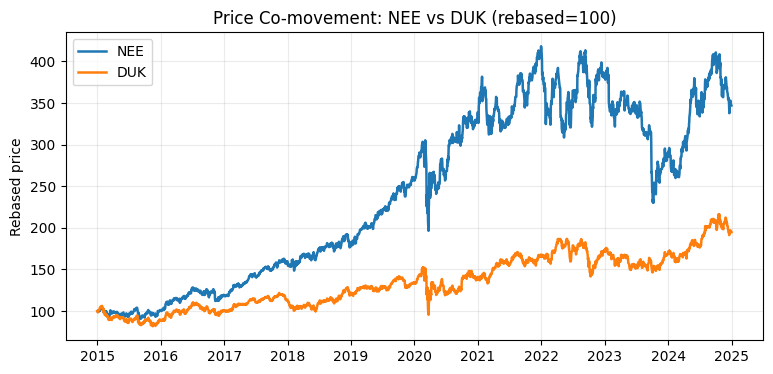

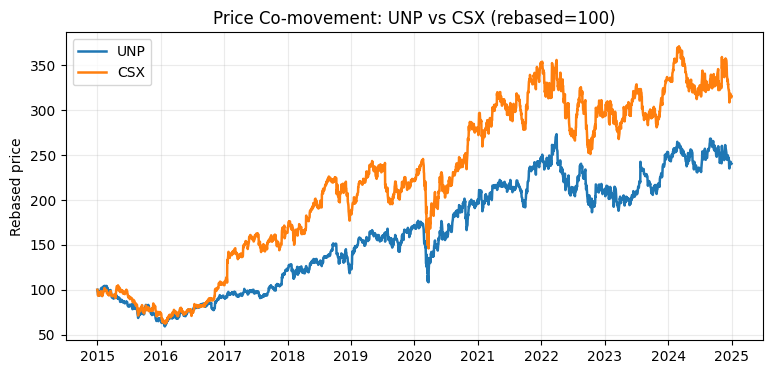

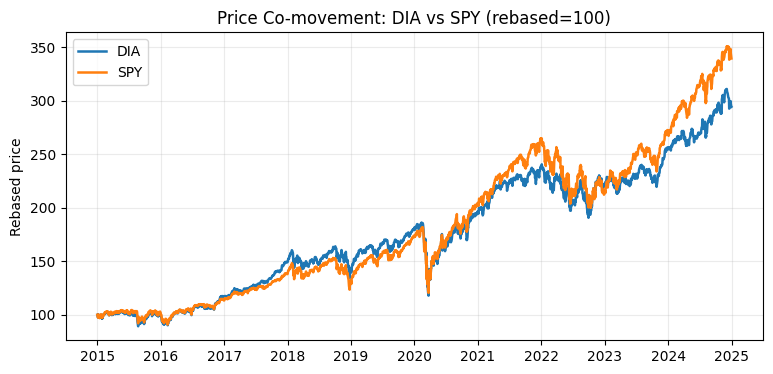

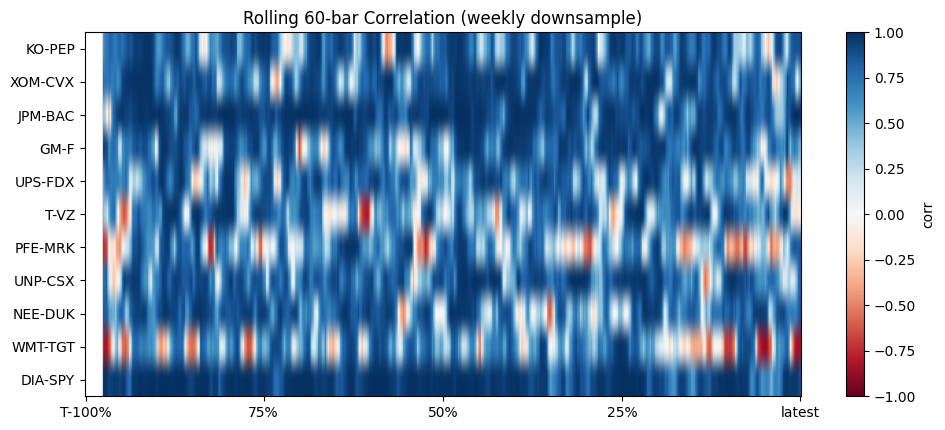

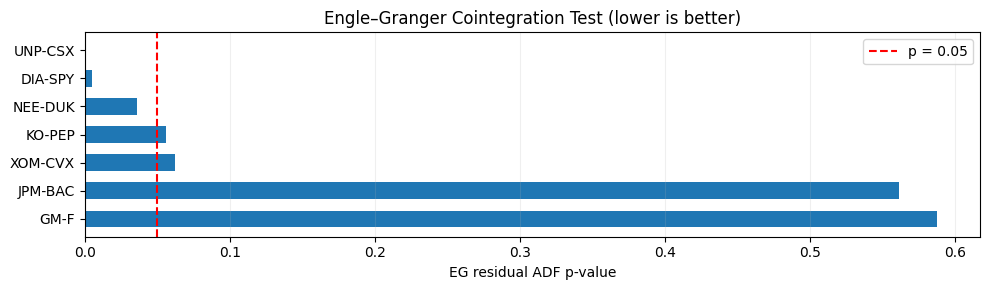

Cointegrated pairs (p<0.05): 3 / 7


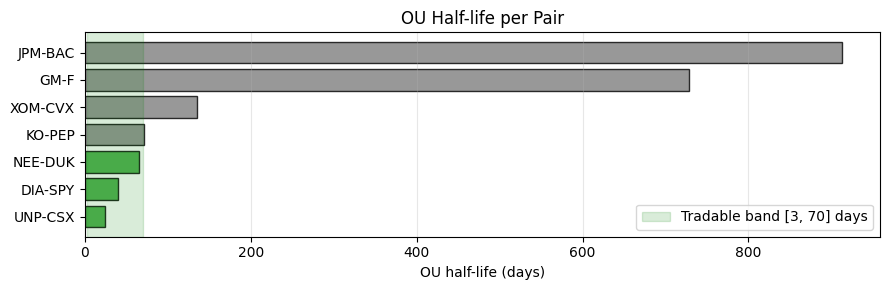

Pairs within tradable half-life band: 3/7 (median = 71.4 days)


In [22]:

# DATA & PRESCREEN

def _have(name):
    return name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty

def _infer_pairs_for_plots(max_pairs=3):
    # priority: pairs_to_feature (if built), else original pairs
    cand = []
    if 'pairs_to_feature' in globals() and pairs_to_feature:
        cand = list(pairs_to_feature)
    elif 'pairs' in globals() and pairs:
        cand = list(pairs)
    # keep only those actually present in prices
    if _have('prices'):
        have_cols = set(prices.columns)
        cand = [p for p in cand if p[0] in have_cols and p[1] in have_cols]
    return cand[:max_pairs]

def _rebased(series):
    s = pd.Series(series).dropna()
    if s.empty: return s
    return 100 * s / s.iloc[0]

def _infer_freq_days(index: pd.Index) -> float:
    if len(index) < 3: return 1.0
    d = pd.Series(index).diff().dropna().median()
    return d.total_seconds() / (24*3600)

# Price Co-Movement: 2–3 pairs
pairs_for_plots = _infer_pairs_for_plots(3)

if _have('prices') and pairs_for_plots:
    fig_count = len(pairs_for_plots)
    for (a, b) in pairs_for_plots:
        fig, ax = plt.subplots(figsize=(9, 4))
        # use log prices if available, else prices
        src = log_prices if 'log_prices' in globals() and isinstance(log_prices, pd.DataFrame) and not log_prices.empty else prices
        yA, yB = src[a].dropna(), src[b].dropna()
        idx = yA.index.intersection(yB.index)
        if len(idx) < 10:
            plt.close(fig)
            continue
        # rebase to 100 for visual comparability
        ax.plot(_rebased(np.exp(yA.reindex(idx)) if src is log_prices else yA.reindex(idx)), label=a, lw=1.8)
        ax.plot(_rebased(np.exp(yB.reindex(idx)) if src is log_prices else yB.reindex(idx)), label=b, lw=1.8)
        ax.set_title(f"Price Co-movement: {a} vs {b} (rebased=100)")
        ax.set_ylabel("Rebased price")
        ax.legend()
        ax.grid(alpha=0.25)
        plt.show()
else:
    print("Skipping co-movement plots (missing `prices` or no valid pairs).")

# Rolling 60-bar correlation heatmap
if _have('log_prices_highfreq') and ('pairs' in globals() and pairs):
    roll_win = 60
    # build wide matrix: columns are "A-B" strings, rows are time
    cats = []
    mats = []
    # choose a manageable subset
    valid_pairs = [(a,b) for (a,b) in pairs if a in log_prices_highfreq.columns and b in log_prices_highfreq.columns]
    for (a,b) in valid_pairs:
        s1 = log_prices_highfreq[a].dropna()
        s2 = log_prices_highfreq[b].dropna()
        idx = s1.index.intersection(s2.index)
        if len(idx) < roll_win+5:
            continue
        rc = s1.reindex(idx).rolling(roll_win).corr(s2.reindex(idx))
        # downsample to weekly for readability
        rcw = rc.resample('W').last()
        cats.append(f"{a}-{b}")
        mats.append(rcw.values)

    if mats:
        # align lengths
        min_len = min(len(m) for m in mats)
        M = np.vstack([m[-min_len:] for m in mats])  # shape: pairs x time
        # plot heatmap (time on x, pairs on y)
        fig, ax = plt.subplots(figsize=(10, max(3, 0.4*len(cats))))
        im = ax.imshow(M, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
        ax.set_yticks(np.arange(len(cats)))
        ax.set_yticklabels(cats)
        ax.set_xticks([0, min_len//4, min_len//2, 3*min_len//4, min_len-1])
        ax.set_xticklabels(["T-100%", "75%", "50%", "25%", "latest"])
        ax.set_title(f"Rolling {roll_win}-bar Correlation (weekly downsample)")
        fig.colorbar(im, ax=ax, label="corr")
        plt.tight_layout()
        plt.show()
    else:
        print("Rolling correlation heatmap skipped (insufficient overlapping data).")
else:
    print("Skipping rolling correlation heatmap (need `log_prices_highfreq` and `pairs`).")

# Engle–Granger p-values bar chart
if _have('eg_df') and "p-value" in eg_df.columns and "Pair" in eg_df.columns:
    df = eg_df[["Pair","p-value"]].dropna().copy()
    if not df.empty:
        df = df.sort_values("p-value")
        fig, ax = plt.subplots(figsize=(10, max(3, 0.35*len(df))))
        ax.barh(df["Pair"], df["p-value"], height=0.6)
        ax.axvline(0.05, color='red', lw=1.5, linestyle='--', label='p = 0.05')
        ax.set_xlabel("EG residual ADF p-value")
        ax.set_title("Engle–Granger Cointegration Test (lower is better)")
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.2)
        ax.legend()
        plt.tight_layout()
        plt.show()

        n_pass = int((df["p-value"] < 0.05).sum())
        print(f"Cointegrated pairs (p<0.05): {n_pass} / {len(df)}")
    else:
        print("eg_df present but empty after dropping NaNs.")
else:
    print("Skipping EG p-value plot (missing `eg_df` with ['Pair','p-value']).")

# OU Half-life by Pair (improved visualization)
if _have('ou_table') and {"half_life","Pair"}.issubset(ou_table.columns):
    df = ou_table[["Pair","half_life"]].dropna()
    df["half_life"] = pd.to_numeric(df["half_life"], errors="coerce")
    df = df.dropna(subset=["half_life"])
    if not df.empty:
        # infer frequency units
        if 'log_prices_highfreq' in globals() and not log_prices_highfreq.empty:
            mdays = _infer_freq_days(log_prices_highfreq.index)
        else:
            mdays = 1.0
        if mdays < 0.2:
            hl_min, hl_max = 10, 120
            units = "hours"
        else:
            hl_min, hl_max = 3, 70
            units = "days"

        # flag tradable band
        df["in_band"] = df["half_life"].between(hl_min, hl_max)

        # sort for clarity
        df = df.sort_values("half_life")

        # plot horizontal bars
        fig, ax = plt.subplots(figsize=(9, max(3, 0.35*len(df))))
        colors = df["in_band"].map({True: "tab:green", False: "tab:gray"})
        ax.barh(df["Pair"], df["half_life"], color=colors, edgecolor="k", alpha=0.8)
        ax.axvspan(hl_min, hl_max, color="green", alpha=0.15,
                   label=f"Tradable band [{hl_min}, {hl_max}] {units}")
        ax.set_xlabel(f"OU half-life ({units})")
        ax.set_title("OU Half-life per Pair")
        ax.grid(axis="x", alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()

        # quick summary
        n_in = int(df["in_band"].sum())
        print(f"Pairs within tradable half-life band: {n_in}/{len(df)} "
              f"(median = {df['half_life'].median():.1f} {units})")
    else:
        print("ou_table present but no numeric half-life values.")
else:
    print("Skipping OU half-life plot (need ou_table with Pair & half_life).")

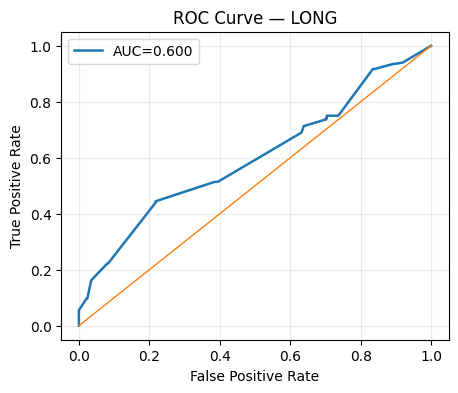

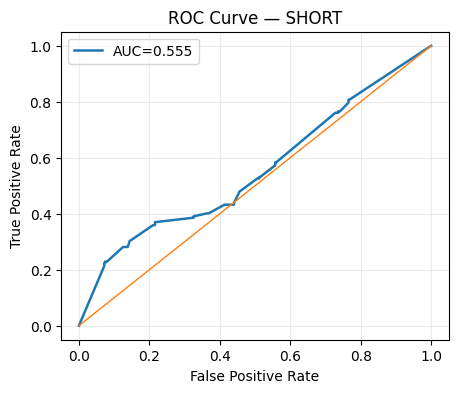

AUC by fold & side:


side,long,short
fold,,
1,0.606,0.416
2,0.717,0.808
3,0.670,0.660


<Figure size 650x400 with 0 Axes>

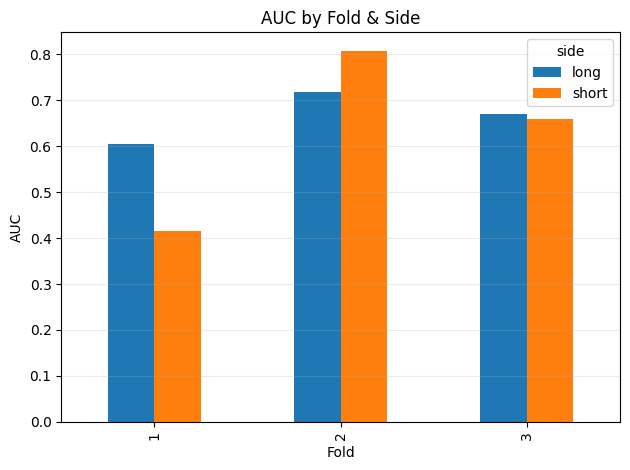

In [23]:

# SECTION 4 — MODEL EVALUATION

from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss

def _ok(df, cols):
    return isinstance(df, pd.DataFrame) and not df.empty and set(cols).issubset(df.columns)

if not _ok(globals().get("svm_preds"), ["label","p_profit","side","fold"]):
    print("Need `svm_preds` with columns: label, p_profit, side, fold.")
else:
    SP = svm_preds.copy().dropna(subset=["p_profit","label"])
    SP["y"] = (SP["label"] == 1).astype(int)

    #  ROC per side
    sides = sorted(SP["side"].dropna().unique())
    for s in sides:
        g = SP[SP["side"] == s]
        if g["y"].nunique() < 2:
            print(f"ROC skipped for side={s} (not enough classes).")
            continue
        fpr, tpr, _ = roc_curve(g["y"], g["p_profit"])
        auc = roc_auc_score(g["y"], g["p_profit"])
        plt.figure(figsize=(5.0,4.0))
        plt.plot(fpr, tpr, lw=1.8, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1], lw=1.0)
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {s.upper()}")
        plt.legend()
        plt.grid(alpha=0.25)
        plt.show()

    # AUC by fold & side (bar plot)
    rows = []
    for (f, s), g in SP.groupby(["fold","side"]):
        if g["y"].nunique() < 2:
            rows.append({"fold": f, "side": s, "auc": np.nan})
        else:
            rows.append({"fold": f, "side": s, "auc": roc_auc_score(g["y"], g["p_profit"])})
    auc_df = pd.DataFrame(rows)
    if not auc_df.empty:
        pivot = auc_df.pivot(index="fold", columns="side", values="auc").sort_index()
        print("AUC by fold & side:")
        display(pivot.round(3))
        plt.figure(figsize=(6.5,4.0))
        pivot.plot(kind="bar")
        plt.title("AUC by Fold & Side")
        plt.xlabel("Fold"); plt.ylabel("AUC")
        plt.grid(axis="y", alpha=0.25)
        plt.tight_layout()
        plt.show()

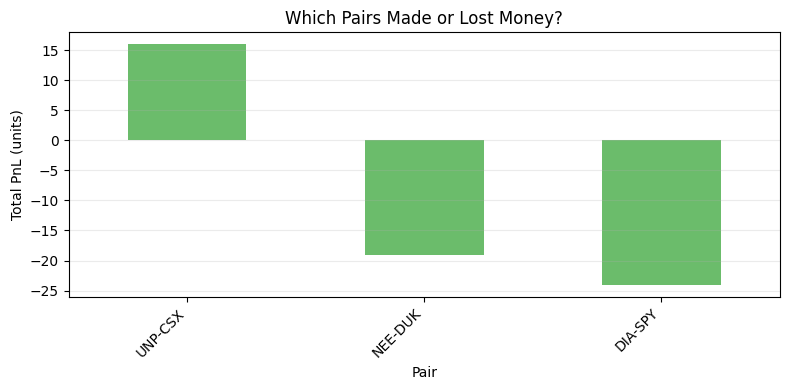

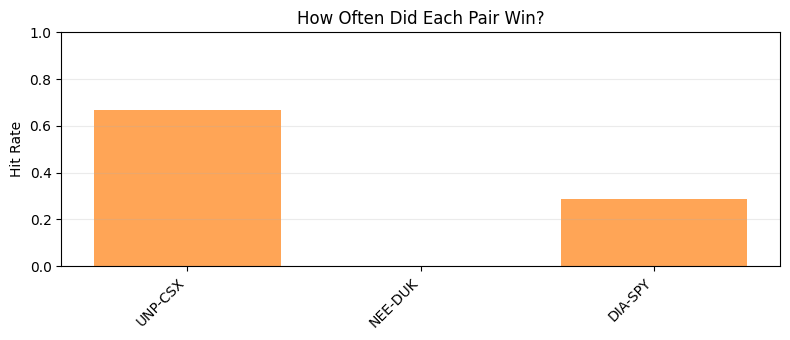

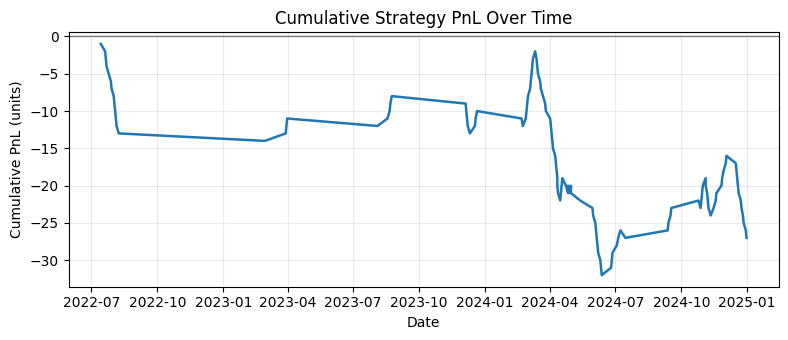

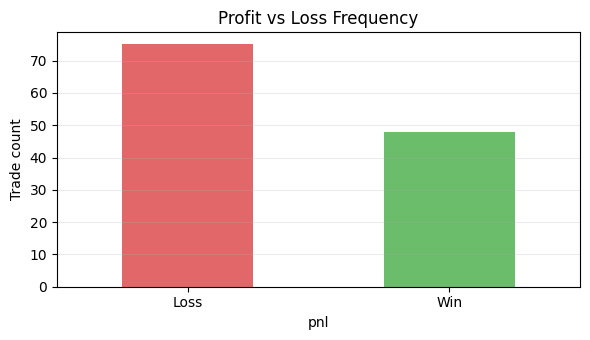

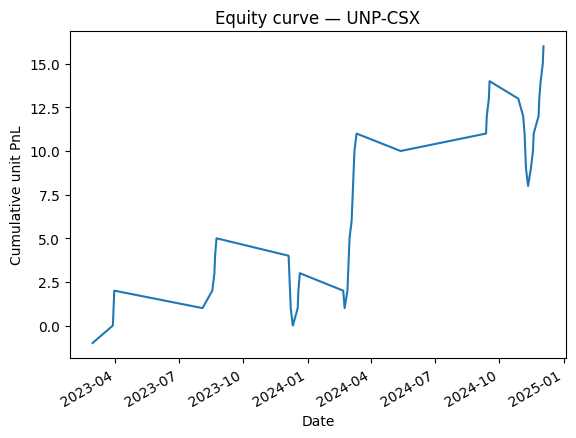

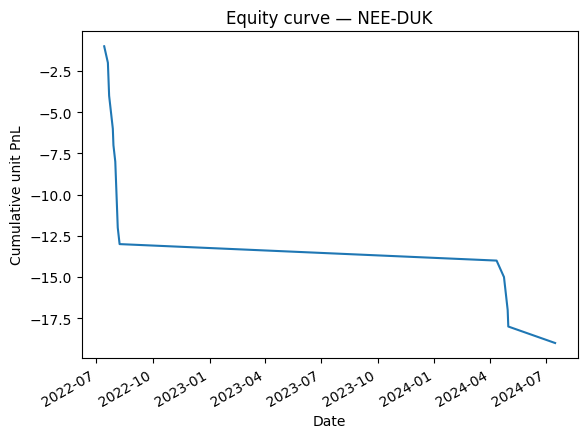

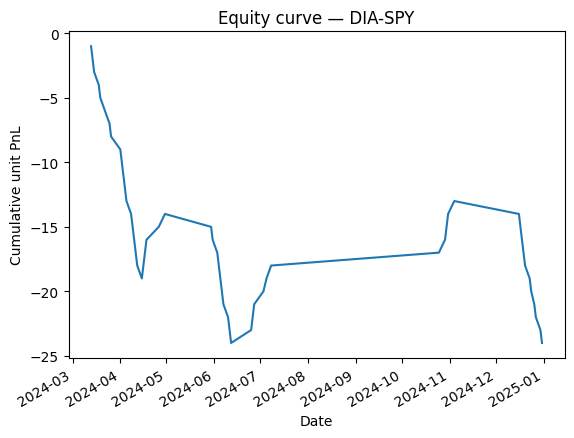

In [24]:


# sanity check
if 'trade_blotter' not in globals() or trade_blotter.empty:
    print("No trades to visualize. Run Step 7–8 first.")
else:
    TB = trade_blotter.copy().sort_index()


    #Per-pair performance: simple and visual
    perf = (TB.groupby("pair")["pnl"]
              .agg(trades="count", hit_rate=lambda s:(s==1).mean(), total_pnl="sum")
              .sort_values("total_pnl", ascending=False))
    if not perf.empty:
        fig, ax1 = plt.subplots(figsize=(8,4))
        perf["total_pnl"].plot(kind="bar", color="tab:green", alpha=0.7, ax=ax1)
        ax1.set_title("Which Pairs Made or Lost Money?")
        ax1.set_ylabel("Total PnL (units)")
        ax1.set_xlabel("Pair")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", alpha=0.25)
        plt.tight_layout()
        plt.show()

        fig, ax2 = plt.subplots(figsize=(8,3.5))
        ax2.bar(perf.index, perf["hit_rate"], color="tab:orange", alpha=0.7)
        ax2.set_title("How Often Did Each Pair Win?")
        ax2.set_ylabel("Hit Rate")
        ax2.set_ylim(0,1)
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", alpha=0.25)
        plt.tight_layout()
        plt.show()

    # Overall equity curve (intuitive growth-over-time story)
    curve = TB.sort_index()["pnl"].cumsum()
    plt.figure(figsize=(8,3.5))
    plt.plot(curve, lw=1.8, color="tab:blue")
    plt.axhline(0, lw=1.0, color="k", alpha=0.5)
    plt.title("Cumulative Strategy PnL Over Time")
    plt.xlabel("Date"); plt.ylabel("Cumulative PnL (units)")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Distribution of trade outcomes (are losses large or frequent?)
    plt.figure(figsize=(6,3.5))
    TB["pnl"].value_counts().reindex([-1,1]).plot(kind="bar", color=["tab:red","tab:green"], alpha=0.7)
    plt.title("Profit vs Loss Frequency")
    plt.xticks([0,1], ["Loss","Win"], rotation=0)
    plt.ylabel("Trade count")
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Per pair equity curves
    for p in pair_results.head(3)["pair"]:
      if not curves[p].empty:
          plt.figure()
          curves[p].plot(title=f"Equity curve — {p}")
          plt.xlabel("Date"); plt.ylabel("Cumulative unit PnL")
          plt.show()